# Fig1: Four-terminal setup for conductance calculations

In [1]:
#********************************************** Importing modules **********************************************#

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from numpy import sin, exp, cos, pi, sqrt
from shapely.geometry import Point, Polygon
import kwant
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os


#********************************************** Defining constants **********************************************#

sin_30, cos_30 = (1. / 2, sqrt(3.) / 2) 
a0 = 2.46 # Honeycomb lattice constant (not nearest-neighbors!) [A]
d0 = 3.35 # Distance between the layers [A]
lcon = a0 / sqrt(3) # Nearest neighbor constant [A]
R0 = a0 * cos_30 + lcon * sin_30 + lcon # Lattice constant with armchair edges
Vppp = 3.09 # Intralayer hopping for graphene [eV]
Vpps =  0.39 # Interlayer hopping for AA stacked Bilayer graphene[eV]
chem_pot = 2 # Chemical potential of the leads
lambda0 = 0.27 # Constant necessary for the interlayer hoppings[A]
k_D = 2 * np.pi / np.sqrt(3) # BZ nearest neighbor constant [A^-1]

#***************************************** Setting up data directories *****************************************#

data_dir = os.path.dirname(os.getcwd()) + '/Data/'
figure_dir = path = os.path.dirname(os.getcwd()) + '/Figures/'

C:\ProgramData\Miniconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


# Figure 1: Twisted Bilayer Graphene setup for conductance calculations

C:\Users\ascie\AppData\Local\Temp\ipykernel_2348\1994661590.py:179: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist
C:\ProgramData\Miniconda3\lib\site-packages\kwant\_plotter.py:316: RuntimeWarning: divide by zero encountered in scalar divide
  return -self.zorder3d + vs[2].mean() / cz.ptp()


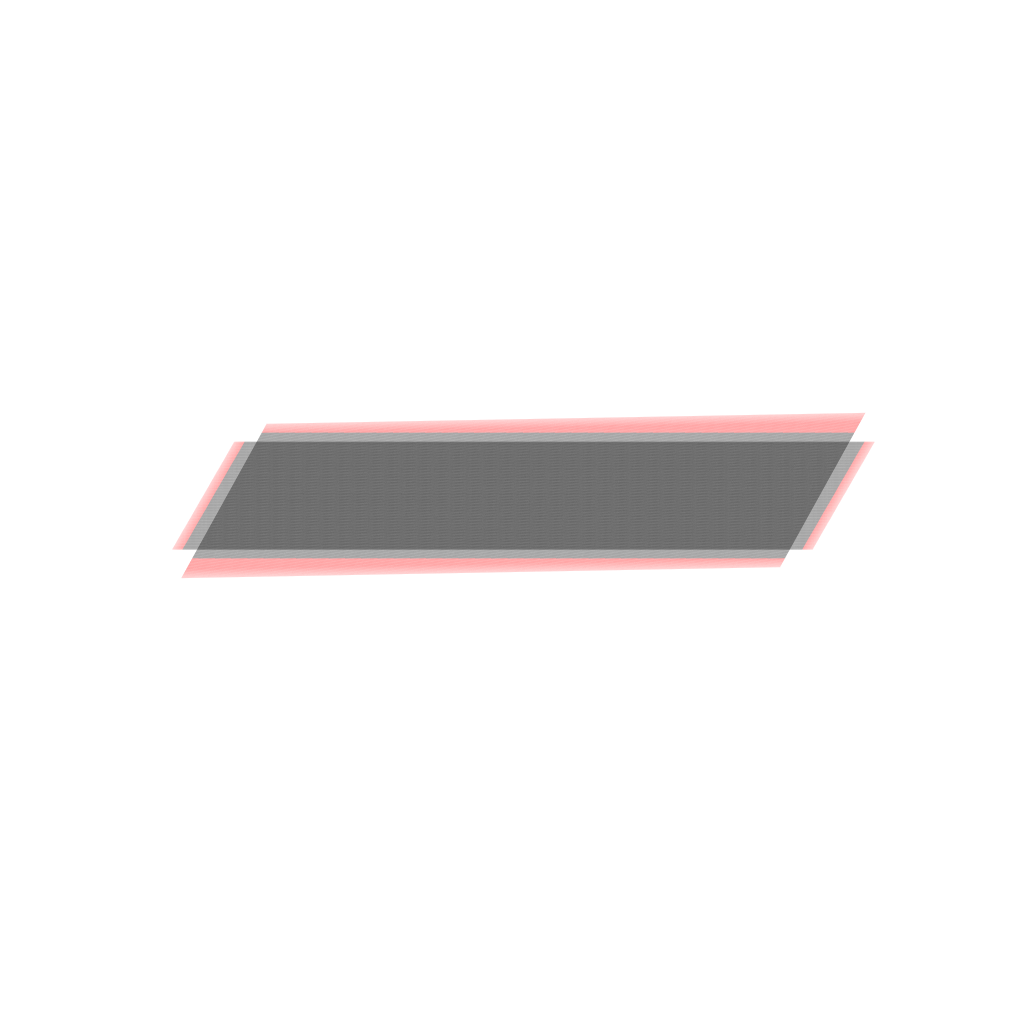

In [4]:
def four_terminal_conductance_setup( NLb=1, NWb=1, NLt=1, NWt=1, stacking = "AA", theta = 0, metallic = True):
    
    '''
        Plots the setup used for four terminal conductance simulations shown in Figure 1:
            - It is only useful for plotting the lattice, this code is not fully functional!
            - NLb(NLt) and NWb(NWt) are the number of translations in length and width of the bottom (top) layer, 
              with a non-standard unit cell of graphene of length R0 (six atoms per unit cell),
            - Stacking, either AA or AB, is the BLG stacking at theta = 0,
            - theta is the twist angle (top layer is rotated),
            - The leads are numered 0-3 and correspond to (left, bottom, top, right),
            - If metallic is set true it adds a few sites to the scattering region so that the spectrum is gapless (semi-metallic).
    '''    

            
    def rotate(angle, vector):
        '''
            Rotates a 3D vector around the z-axis 
        '''
        M = np.array([
            [cos(angle),-sin(angle),0],
            [sin(angle),cos(angle),0],
            [0,0,1]
        ])
        return M @ vector

    theta = np.radians(theta)
    
    a1 = np.array([0,0,0])
    a2 = np.array([sin_30,-cos_30,0]) * lcon
    a3 = np.array([cos_30,-sin_30,0]) * a0
    a4 = np.array([1,0,0]) * (R0 - lcon)
    a5 = np.array([cos_30,sin_30,0]) * a0
    a6 = np.array([sin_30,cos_30,0]) * lcon
    
    bot_basis = [a1,a2,a3,a4,a5,a6]
    
    V1_bot = R0 * np.array([1, 0, 0]) # Primitive vectors
    V2_bot = R0 * np.array([sin_30,cos_30, 0])
    V1_top = rotate(theta,V1_bot)
    V2_top = rotate(theta,V2_bot)

    v1 = np.array([0,0,d0])
    
    if stacking == "AB":
        v1 += np.array([lcon*sin_30,lcon*cos_30,0])
        
    top_basis = []
    for atom in bot_basis:
        top_basis.append(rotate(theta,atom) + v1)  
        
    bot_lat = kwant.lattice.general([V1_bot,V2_bot],bot_basis,norbs=1)    
    top_lat = kwant.lattice.general([V1_top,V2_top],top_basis,norbs=1)
    
    syst = kwant.Builder()
    bot_lead = kwant.Builder(kwant.TranslationalSymmetry(-V1_bot))
    top_lead = kwant.Builder(kwant.TranslationalSymmetry(-V2_top))
    
    NLbs = -int(NLb / 2)
    NWbs = -int(NWb / 2)
    NLts = -int(NLt / 2)
    NWts = -int(NWt / 2)
    
    ab,bb,cb,db,eb,fb = bot_lat.sublattices
    at,bt,ct,dt,et,ft = top_lat.sublattices
    
    
    ymin = -lcon * cos_30 + v1[1] + (NWts * R0 * cos_30)
    ymax = -ymin
    
    displacement = np.array(at(NLts,NWt + NWts).pos)
    ydif = ymax - displacement[1]
    extra_translations = int(ydif / (R0 * cos_30))

    NWts += - extra_translations
    NWt += 2 *  extra_translations
    
    
    def chem_potential(site):
        x,y,z = site.pos
        if y >= ymin and y <= ymax:
            return 0
        else:
            return -chem_pot
    
    for j in range(NWb):
        
        bot_lead[ab(NLbs,j+NWbs)] = -chem_pot
        bot_lead[bb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[cb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[db(NLbs,j+NWbs)] = -chem_pot
        bot_lead[eb(NLbs,j+NWbs)] = -chem_pot
        bot_lead[fb(NLbs,j+NWbs)] = -chem_pot
        
        for i in range(NLb):
            
            syst[ab(i+NLbs,j+NWbs)] = 0.
            syst[bb(i+NLbs,j+NWbs)] = 0.
            syst[cb(i+NLbs,j+NWbs)] = 0.
            syst[db(i+NLbs,j+NWbs)] = 0. 
            syst[eb(i+NLbs,j+NWbs)] = 0.
            syst[fb(i+NLbs,j+NWbs)] = 0.
            
        
    for i in range(NLt):
        
        top_lead[at(NLts+i,NWts)] = -chem_pot
        top_lead[bt(NLts+i,NWts)] = -chem_pot
        top_lead[ct(NLts+i,NWts)] = -chem_pot
        top_lead[dt(NLts+i,NWts)] = -chem_pot
        top_lead[et(NLts+i,NWts)] = -chem_pot
        top_lead[ft(NLts+i,NWts)] = -chem_pot
        
        for j in range(NWt):
            
            syst[at(i+NLts,j+NWts)] = chem_potential
            syst[bt(i+NLts,j+NWts)] = chem_potential
            syst[ct(i+NLts,j+NWts)] = chem_potential
            syst[dt(i+NLts,j+NWts)] = chem_potential 
            syst[et(i+NLts,j+NWts)] = chem_potential
            syst[ft(i+NLts,j+NWts)] = chem_potential 
    
    if metallic:
        
        for i in range(NLb):

            syst[bb(i + NLbs,NWb + NWbs)] = 0
            syst[cb(i + NLbs,NWb + NWbs)] = 0
            syst[ab(i + NLbs,NWb + NWbs)] = 0
            syst[db(i + NLbs,NWb + NWbs)] = 0

        for j in range(NWb):

            syst[ab(NLb + NLbs,j + NWbs)] = 0
            syst[bb(NLb + NLbs,j + NWbs)] = 0
            syst[eb(NLb + NLbs,j + NWbs)] = 0
            syst[fb(NLb + NLbs,j + NWbs)] = 0

        bot_lead[bb( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[cb( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[ab( NLbs,NWb + NWbs)] = -chem_pot
        bot_lead[db( NLbs,NWb + NWbs)] = -chem_pot


        for j in range(NWt):

            syst[bt(NLt + NLts,j + NWts)] = chem_potential
            syst[et(NLt + NLts,j + NWts)] = chem_potential
            syst[at(NLt + NLts,j + NWts)] = chem_potential
            syst[ft(NLt + NLts,j + NWts)] = chem_potential

        for i in range(NLt):

            syst[bt(i + NLts,NWt + NWts)] = chem_potential
            syst[ct(i + NLts,NWt + NWts)] = chem_potential
            syst[at(i + NLts,NWt + NWts)] = chem_potential
            syst[dt(i + NLts,NWt + NWts)] = chem_potential

        top_lead[bt(NLt + NLts, NWts)] = -chem_pot
        top_lead[et(NLt + NLts, NWts)] = -chem_pot
        top_lead[at(NLt + NLts, NWts)] = -chem_pot
        top_lead[ft(NLt + NLts, NWts)] = -chem_pot
    

    syst[bot_lat.neighbors()] = -Vppp
    bot_lead[bot_lat.neighbors()] = -Vppp
    syst[top_lat.neighbors()] = -Vppp
    top_lead[top_lat.neighbors()] = -Vppp
    

    syst.attach_lead(bot_lead)
    syst.attach_lead(top_lead)
    syst.attach_lead(top_lead.reversed())
    syst.attach_lead(bot_lead.reversed())
        
    azim, dist, elev = -90, 8, 90 # Default: -60, 10, 30, View from above: -90, 10, 90
    fig = plt.figure(figsize=(50,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.azim = azim
    ax.dist = dist
    ax.elev = elev
    ax.set_axis_off()
    
    def site_color(site):
        x,y,z = site.pos
        if y >= ymin and y <= ymax:
            return 'k'
        else:
            return 'r'

    kwant.plot(syst,site_size = 0.30, site_color=site_color, site_edgecolor = site_color, hop_lw = 0.0, hop_color = 'w', 
               ax = ax,num_lead_cells = 10, lead_color='r', lead_site_edgecolor = 'r');
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.tight_layout(pad=0)
    plt.savefig(figure_dir + 'fig1.png')
    plt.show()
    plt.close()


#********************************** Example with parameters used in the paper **********************************#


four_terminal_conductance_setup( NLb=600, NWb=120, NLt=580, NWt=140, stacking = "AA", theta = 1.05, metallic = True)


# Figure 2: Minimal conductance as a function of twist-angle and interlayer hopping

In [3]:

#************************************************* Loading data *************************************************#


ang_conductance_dir = data_dir + '/Conductance/Angle dependance/'
hop_conductance_dir = data_dir + '/Conductance/Interlayer hopping dependance/'

angles = np.load(ang_conductance_dir + '/angles.npy')
hop_amplitudes = np.load(hop_conductance_dir + 'hop_amplitudes.npy')
Gs_ang = np.load(ang_conductance_dir + '/conductance_matrices.npy')
Gs_hop = np.load(hop_conductance_dir + '/conductance_matrices.npy')

#***************************************** Extracting the conductances ******************************************#

G10s_ang = []
G20s_ang = []
G30s_ang = []
G12s_ang = []
G31s_ang = []
G32s_ang = []

for i in range(len(angles)):

    G10s_ang.append(-Gs_ang[i][1,0])
    G20s_ang.append(-Gs_ang[i][2,0])
    G30s_ang.append(-Gs_ang[i][3,0])
    G12s_ang.append(-Gs_ang[i][1,2])
    G31s_ang.append(-Gs_ang[i][3,1])
    G32s_ang.append(-Gs_ang[i][3,2])
    
G10s_hop = []
G20s_hop = []
G30s_hop = []
G12s_hop = []
G31s_hop = []
G32s_hop = []

for i in range(len(hop_amplitudes)):

    G10s_hop.append(-Gs_hop[i][1,0])
    G20s_hop.append(-Gs_hop[i][2,0])
    G30s_hop.append(-Gs_hop[i][3,0])
    G12s_hop.append(-Gs_hop[i][1,2])
    G31s_hop.append(-Gs_hop[i][3,1])
    G32s_hop.append(-Gs_hop[i][3,2])

<ipython-input-4-aaca4c56edff>:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


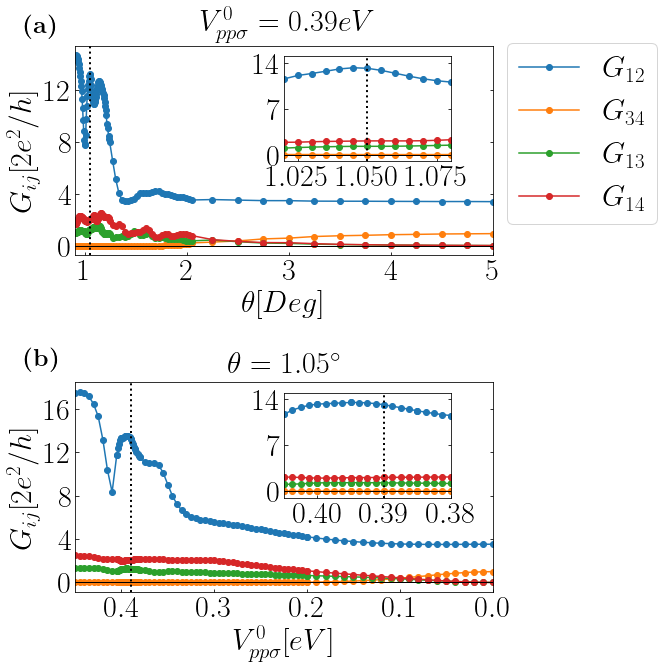

In [4]:
#*************************************************** Plotting ***************************************************#

plt.rcParams.update({'font.size': 30})
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize = (10,10))

ax1 = plt.subplot(211)

ax1.plot(angles,G12s_ang,marker = 'o', label = "$G_{12}$", c = colors[0])
ax1.plot(angles,G30s_ang,marker = 'o', label = "$G_{34}$", c = colors[1])
ax1.plot(angles,G20s_ang,marker = 'o', label = "$G_{13}$", c = colors[2])
ax1.plot(angles,G32s_ang,marker = 'o', label = "$G_{14}$", c = colors[3])
ax1.axhline(0, lw=1, c='k', ls='-')
ax1.axvline(1.05, lw=2, c='k', ls=':')

ax1.legend(loc = (1.035,0.15), fontsize = 30, frameon=True) 

ax1.set_xlim(0.9,5)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel(r"$\theta [Deg]$")
ax1.set_ylabel("$G_{ij} [2 e^2 / h]$")
ax1.set_title("$V_{pp\sigma}^0 = 0.39eV$", fontsize = 30, pad = 15)

axins1 = inset_axes(ax1, width="100%", height="100%", loc='upper right',
                    bbox_to_anchor=(0.50,0.45,0.40,0.5),
                    bbox_transform=ax1.transAxes, borderpad=0)

axins1.plot(angles,G12s_ang,marker = 'o', label = "G12", c = colors[0])
axins1.plot(angles,G30s_ang,marker = 'o', label = "G34", c = colors[1])
axins1.plot(angles,G20s_ang,marker = 'o', label = "G13", c = colors[2])
axins1.plot(angles,G32s_ang,marker = 'o', label = "G14", c = colors[3])

axins1.axhline(0, lw=1, c='k', ls='-')
axins1.axvline(1.05, lw=2, c='k', ls=':')
axins1.set_xlim(1.02,1.08)
axins1.set_ylim(-1,15)

ax2 = plt.subplot(212)
ax2.plot(hop_amplitudes,G12s_hop,marker = 'o', label = "G12", c = colors[0])
ax2.plot(hop_amplitudes,G30s_hop,marker = 'o', label = "G34", c = colors[1])
ax2.plot(hop_amplitudes,G20s_hop,marker = 'o', label = "G13", c = colors[2])
ax2.plot(hop_amplitudes,G32s_hop,marker = 'o', label = "G14", c = colors[3])
ax2.axhline(0, lw=1, c='k', ls='-')

ax2.invert_xaxis()
ax2.set_xlim(0.45,0)
ax2.axvline(0.39, lw=2, c='k', ls=':')
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.set_xlabel("$V_{pp\sigma}^0 [eV]$")
ax2.set_ylabel("$G_{ij} [2 e^2 / h]$")
ax2.set_title(r'$\theta = 1.05^\circ$', fontsize = 30, pad = 10)


    

axins2 = inset_axes(ax2, width="100%", height="100%", loc='upper right',
                   bbox_to_anchor=(0.50,0.45,0.4,0.5),
                   bbox_transform=ax2.transAxes, borderpad=0)

axins2.plot(hop_amplitudes,G12s_hop,marker = 'o', label = "G12")
axins2.plot(hop_amplitudes,G30s_hop,marker = 'o', label = "G34")
axins2.plot(hop_amplitudes,G20s_hop,marker = 'o', label = "G13")
axins2.plot(hop_amplitudes,G32s_hop,marker = 'o', label = "G14")
axins2.axhline(0, lw=1, c='k', ls='-')

axins2.set_xlim(0.405,0.380)
axins2.set_ylim(-1,15)
axins2.axvline(0.39, lw=2, c='k', ls=':')


for ax in [ax1, ax2, axins1, axins2]:
    ax.tick_params(direction='in', right=True, top=False)
    
for ax in [axins1, axins2]:
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_yticks([0,7,14])


plt.tight_layout()
ax1.text(x = 0.4,y = 16.5, s = r'$\textbf{(a)}$', fontsize = 25)
ax2.text(x = 0.505,y = 20, s = r'$\textbf{(b)}$', fontsize = 25)

plt.savefig(figure_dir + 'fig2.pdf')
plt.show()
plt.close()

# Figure 3: Minimal conductance as a function of system size

In [5]:
#******************************************* Locating the files path *******************************************#

size_data_dir = data_dir + '/Conductance/Lattice size dependance/'

theta_1 = 1.20
theta_2 = 1.30
theta_3 = 10.0
Vpps = 0.390

#********************************************* Extracting the data ********************************************#

sizes_1 = np.load(size_data_dir + 'theta={:.2f}_Vpps={:.3f}/sizes.npy'.format(theta_1, Vpps))
sizes_2 = np.load(size_data_dir + 'theta={:.2f}_Vpps={:.3f}/sizes.npy'.format(theta_2, Vpps))
sizes_3 = np.load(size_data_dir + 'theta={:.2f}_Vpps={:.3f}/sizes.npy'.format(theta_3, Vpps))

Gs_1 = np.load(size_data_dir + 'theta={:.2f}_Vpps={:.3f}/conductance_matrices.npy'.format(theta_1, Vpps))
Gs_2 = np.load(size_data_dir + 'theta={:.2f}_Vpps={:.3f}/conductance_matrices.npy'.format(theta_2, Vpps))
Gs_3 = np.load(size_data_dir + 'theta={:.2f}_Vpps={:.3f}/conductance_matrices.npy'.format(theta_3, Vpps))

#***************************************** Extracting the conductances ******************************************#

G12s_1 = []
G12s_2 = []
G12s_3 = []


for i in range(len(Gs_1)):
    G12s_1.append(-Gs_1[i][1,2])
    
for i in range(len(Gs_2)):
    G12s_2.append(-Gs_2[i][1,2])

for i in range(len(Gs_3)):
    G12s_3.append(-Gs_3[i][1,2])

    
#****************************************** Converting the sizes to nm ******************************************#


sizes_nm_1 = []
sizes_nm_2 = []
sizes_nm_3 = []

for size in sizes_1:
    sizes_nm_1.append(int(size[0:3]) * R0 / 10)
for size in sizes_2:
    sizes_nm_2.append(int(size[0:3]) * R0 / 10)
for size in sizes_3:
    sizes_nm_3.append(int(size[0:3]) * R0 / 10)

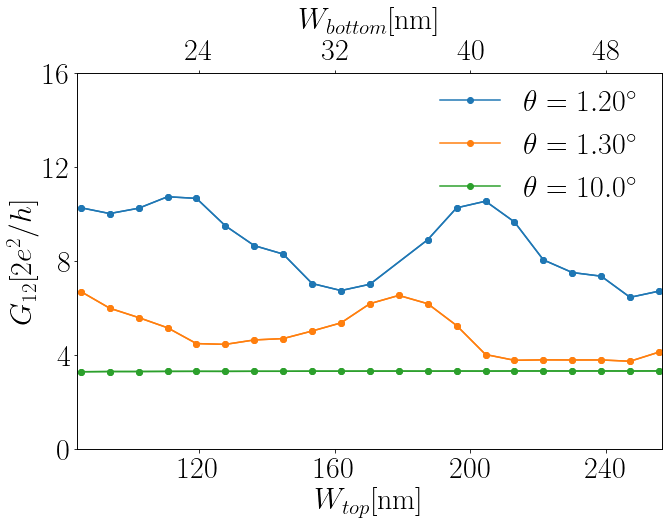

In [6]:
#*************************************************** Plotting ***************************************************#

plt.rcParams.update({'font.size': 30})
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig,ax1 = plt.subplots(figsize = (10,8))

ax1.plot(sizes_nm_1,G12s_1,marker = 'o', label =  r"$\theta = 1.20^\circ$", c = colors[0])
ax1.plot(sizes_nm_2,G12s_2,marker = 'o', label =  r"$\theta = 1.30^\circ$",c = colors[1])
ax1.plot(sizes_nm_3,G12s_3,marker = 'o', label =  r"$\theta = 10.0^\circ$", c = colors[2])
#ax1.plot(sizes_nm_3, np.array(G12s_3) * 2,ls = '--', c = 'k')

ax1.set_ylim(0,16)
ax1.set_xlim(min(sizes_nm_1) - 1, max(sizes_nm_1) + 1)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel(r"$W_{top}$" + "[nm]")
ax1.set_ylabel("$G_{12} [2 e^2 / h]$")
ax1.legend(loc = (0.6, 0.625), frameon = False)

ax3 = ax1.twiny()
ax3.plot(np.array(sizes_nm_1) / 5, G12s_1,marker = 'o',  c = colors[0])
ax3.plot(np.array(sizes_nm_2) / 5, G12s_2,marker = 'o',  c = colors[1])
ax3.plot(np.array(sizes_nm_3) / 5, G12s_3,marker = 'o',  c = colors[2])

ax3.yaxis.set_major_locator(plt.MaxNLocator(5))
ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
ax3.set_xlabel(r"$W_{bottom}$" + "[nm]",labelpad=10)
ax3.set_xlim((min(sizes_nm_1) - 1) / 5, (max(sizes_nm_1) + 1) / 5)
ax3.set_ylim(0,16)

plt.tight_layout()
plt.savefig(figure_dir + 'fig3.pdf')
plt.show()
plt.close()

# Figure 4: Low-energy conductance and bulk Density Of States comparison

In [7]:
#**************************************** Loading DOS and spectrum data ****************************************#

angles = [1.12, 1.05, 1.02, 1.05]
hops = [0.390, 0.390, 0.390, 0.403]

dos_dir = data_dir + '/DOS/' 
spec_dir = data_dir + '/Spectrum/'
cond_dir = data_dir + '/Conductance/'


energies_dos, N_states = [], []
energies_linear_spectrum = []
energies_cond = []
Gs = []


for i in range(len(angles)):
    
    energies_dos_temp = np.load(dos_dir + 'theta={:.2f}_Vpps={:.3f}/'.format(angles[i],hops[i]) +  'energies.npy')
    N_states_temp = np.load(dos_dir + 'theta={:.2f}_Vpps={:.3f}/'.format(angles[i],hops[i]) +  'N_states.npy')
    energies_linear_spectrum_temp = np.load(spec_dir + 'theta={:.2f}_Vpps={:.3f}/'.format(angles[i],hops[i]) +  'linear_energies.npy')

    energies_cond_temp = np.load(cond_dir + 'theta={:.2f}_Vpps={:.3f}/'.format(angles[i],hops[i]) +  'energies.npy')
    G_temp = np.load(cond_dir + 'theta={:.2f}_Vpps={:.3f}/'.format(angles[i],hops[i]) +  'conductance_matrices.npy') 
    
    #****************** Converting the energy to meV and fixing the Fermi level to E = 0 ******************#

    energies_dos_temp = np.array(energies_dos_temp) * 1000
    energies_linear_spectrum_temp = np.array(energies_linear_spectrum_temp) * 1000
    energies_cond_temp = np.array(energies_cond_temp) * 1000
    
    fermi_level_temp = sum(energies_linear_spectrum_temp[0][0:4]) / 4
    
    energies_dos_temp += -fermi_level_temp
    energies_linear_spectrum_temp += -fermi_level_temp
    energies_cond_temp += -fermi_level_temp

    #********************************************** Storing **********************************************#
    
    energies_dos.append(energies_dos_temp)
    N_states.append(N_states_temp)
    energies_linear_spectrum.append(energies_linear_spectrum_temp)
    energies_cond.append(energies_cond_temp)
    Gs.append(G_temp)   


#***************************************** Extracting the conductances ******************************************#

G10s = []
G20s = []
G30s = []
G12s = []
G31s = []
G32s = []

for i in range(len(angles)):
    G10s_temp = []
    G20s_temp = []
    G30s_temp = []
    G12s_temp = []
    G31s_temp = []
    G32s_temp = []
    
    for j in range(len(energies_cond[i])):

        G10s_temp.append(-Gs[i][j][1,0])
        G20s_temp.append(-Gs[i][j][2,0])
        G30s_temp.append(-Gs[i][j][3,0])
        G12s_temp.append(-Gs[i][j][1,2])
        G31s_temp.append(-Gs[i][j][3,1])
        G32s_temp.append(-Gs[i][j][3,2])
        
    G10s.append(G10s_temp)
    G20s.append(G20s_temp)
    G30s.append(G30s_temp)
    G12s.append(G12s_temp)
    G31s.append(G31s_temp)
    G32s.append(G32s_temp)

In [8]:
#********************************* Adding the VHS peaks and the crossing points *********************************#
            
column_1_VHS = [energies_dos[0][1576], energies_dos[0][1765]]
column_2_VHS = [energies_dos[1][333], energies_dos[1][484]]
column_3_VHS = [energies_dos[2][127], energies_dos[2][200], energies_dos[2][289], energies_dos[2][305]]
column_4_VHS = [energies_dos[3][52], energies_dos[3][129], energies_dos[3][214], energies_dos[3][231]]

column_1_crossings = [-3.5, 3.5]
column_2_crossings = [-1.33, 1.14]
column_3_crossings = [-0.52, -0.0645, 0.31]
column_4_crossings = [-0.50, 0.275]


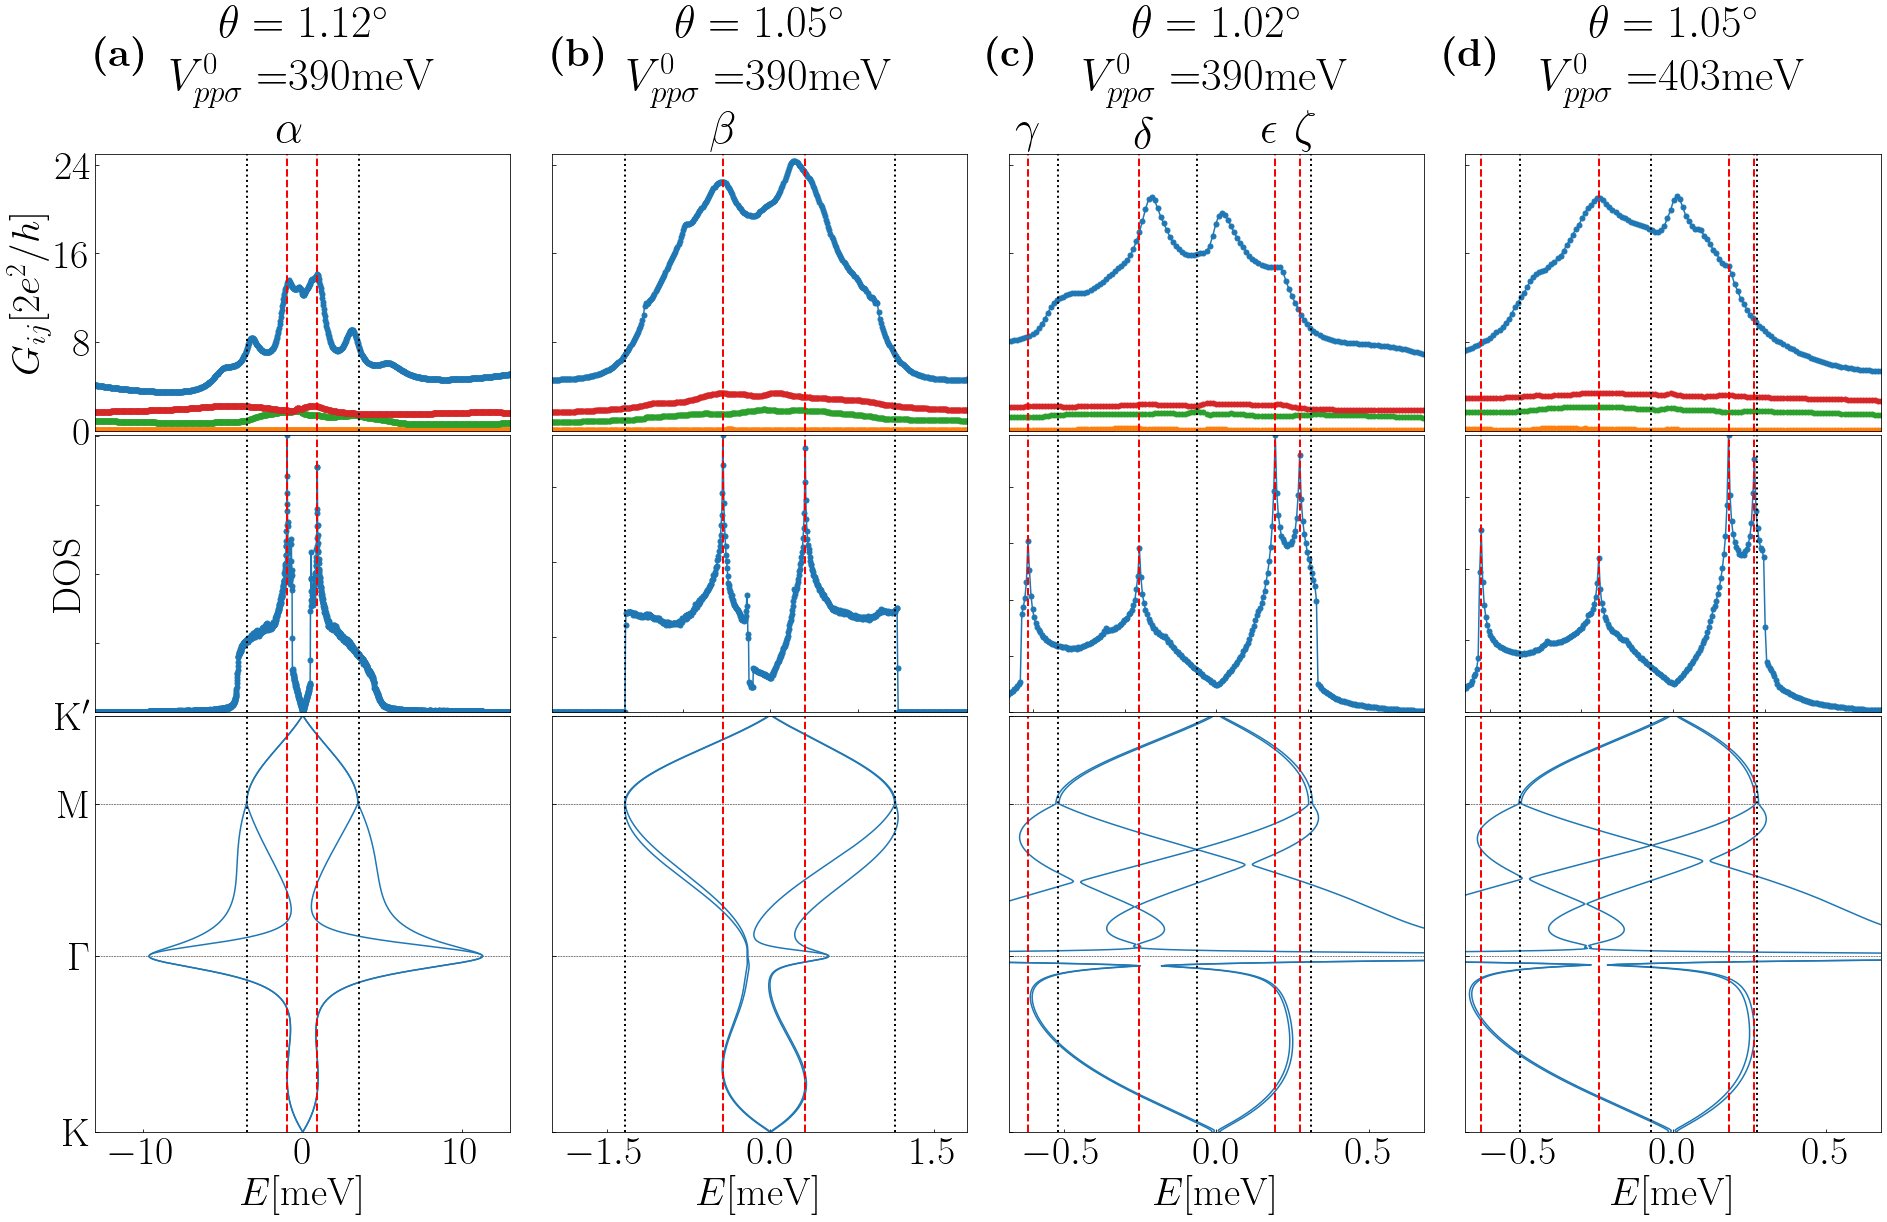

In [9]:
#*************************************************** Plotting ***************************************************#

E_ranges = [(-13 , 13),(-2, 1.8),(-0.68, 0.68),(-0.68,0.68)]

plt.rcParams.update({'font.size': 40})
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

gs_kw = dict(wspace=0.1, hspace=0.01, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1.5])

fig, axs = plt.subplot_mosaic([['11', '12', '13', '14'],
                               ['21', '22', '23', '24'],
                               ['31', '32', '33', '34']],
                              gridspec_kw=gs_kw, figsize=(32, 18),
                              constrained_layout=False)

for i, label in enumerate(['11', '12', '13', '14']):
    
    energies_cond_temp = energies_cond[i]
    G12s_temp = G12s[i]
    G30s_temp = G30s[i]
    G20s_temp = G20s[i]
    G32s_temp = G32s[i]
    

    axs[label].plot(energies_cond_temp,G12s_temp,marker = 'o', ms = 5, label = "G12 (top -> bottom)")
    axs[label].plot(energies_cond_temp,G30s_temp,marker = 'o', ms = 5, label = "G30 (left -> right)")
    axs[label].plot(energies_cond_temp,G20s_temp,marker = 'o', ms = 5, label ="G20 (left -> top)")
    axs[label].plot(energies_cond_temp,G32s_temp,marker = 'o', ms = 5, label = "G32 (top -> right)")
    
    axs[label].set_xlim(E_ranges[i])
    axs[label].set_ylim((-0.1,25)) 
    axs[label].yaxis.set_major_locator(plt.MaxNLocator(4))
    axs[label].set_xticklabels([])
    if label != '11':
        axs[label].set_yticklabels([])
    axs[label].tick_params(direction='in', right=False, top=False)
    
axs['11'].set_ylabel("$G_{ij} [2 e^2 /  h]$")
    

    
    
for i, label in enumerate(['21', '22', '23', '24']):
    
    
    energies_dos_temp = energies_dos[i]
    N_states_temp = np.array(N_states[i]) / sum(N_states[i]) 

    

    axs[label].plot(energies_dos_temp,N_states_temp,marker = 'o', ms = 5)
    axs[label].set_xlim(E_ranges[i])
    axs[label].set_ylim((-0.00001, max(N_states_temp)))
    axs[label].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[label].yaxis.set_major_locator(plt.MaxNLocator(5))
    axs[label].set_xticklabels([])
    axs[label].set_yticklabels([])
    axs[label].tick_params(direction='in', right=False, top=False)
    
axs['21'].set_ylabel("$\mathrm{DOS}$")

for i, label in enumerate(['31', '32', '33', '34']):
    

    linear_energies_temp = energies_linear_spectrum[i]
    N = len(linear_energies_temp) 
    Ns = np.linspace(0, N, N )

    axs[label].plot(linear_energies_temp, Ns, color = colors[0])
        
    
    axs[label].set_xlim(E_ranges[i])
    axs[label].set_ylim([0,N])
    axs[label].xaxis.set_major_locator(plt.MaxNLocator(3))
    axs[label].set_yticks([0, N / (1+cos_30+sin_30), N * (1+cos_30) / (1+cos_30+sin_30), N])   
    axs[label].set_xlabel("$E [\mathrm{meV}]$")
    axs[label].set_yticklabels([])
    axs[label].hlines([0, N / (1+cos_30+sin_30), N * (1+cos_30) / (1+cos_30+sin_30), N],
               xmin = E_ranges[i][0], xmax = E_ranges[i][1],ls ='dashed',lw = 0.5, color = 'k')
    axs[label].tick_params(direction='in', right=False, top=False)
    
axs['31'].set_yticklabels(['$\mathrm{K}$','$\Gamma$','$\mathrm{M}$','$\mathrm{K}\'$'])
    
    

for label in ['11', '21', '31']:
    for peak_marker in column_1_VHS:
        axs[label].axvline(peak_marker, color = 'r', ls = '--', lw = 2)
    for peak_marker in column_1_crossings:
        axs[label].axvline(peak_marker, color = 'k', ls = ':', lw = 2)

for label in ['12', '22', '32']:
    for peak_marker in column_2_VHS:
        axs[label].axvline(peak_marker, color = 'r', ls = '--', lw = 2)
    for peak_marker in column_2_crossings:
        axs[label].axvline(peak_marker, color = 'k', ls = ':', lw = 2)
        
for label in ['13', '23', '33']:
    for peak_marker in column_3_VHS:
        axs[label].axvline(peak_marker, color = 'r', ls = '--', lw = 2)
    for peak_marker in column_3_crossings:
        axs[label].axvline(peak_marker, color = 'k', ls = ':', lw = 2)
        
for label in ['14', '24', '34']:
    for peak_marker in column_4_VHS:
        axs[label].axvline(peak_marker, color = 'r', ls = '--', lw = 2)
    for peak_marker in column_4_crossings:
        axs[label].axvline(peak_marker, color = 'k', ls = ':', lw = 2)
    axs[label].axvline(-0.0725, color = 'k', ls = ':', lw = 2)
            
        
for angle, hop, label in [(angles[0], hops[0], '11'), (angles[1], hops[1], '12'),
                                 (angles[2], hops[2], '13'), (angles[3], hops[3], '14')]:
    
    hop *= 1000
    axs[label].set_title(r'$\theta={:.2f}^\circ$'.format(angle) +  '\n $V_{pp\sigma}^0=$' + 
                         '${:.0f}$'.format(hop) +  '$\mathrm{meV}$' + '\n', fontsize = 45)

    
for label, label_indeks, x, y in [(r'$\textbf{(a)}$', '11', -13, 33), (r'$\textbf{(b)}$', '12', -2.0, 33), 
                                  (r'$\textbf{(c)}$', '13', -0.75, 33), (r'$\textbf{(d)}$', '14', -0.75, 33)]:
    axs[label_indeks].text(x,y,label, fontsize = 40)
    
for label, label_indeks, x, y in [(r'$\alpha$', '11', -1.7, 26), (r'$\beta$', '12', -0.55, 26), (r'$\gamma$', '13', -0.66, 26),
                                  (r'$\delta$', '13', -0.27, 25.5), (r'$\epsilon$', '13', 0.15 , 26), (r'$\zeta$', '13', 0.26, 26)]:

    axs[label_indeks].text(x,y,label, fontsize = 45)
    

fig.savefig(figure_dir + 'fig4.png')
plt.show()
plt.close()



# Figure 5: Fermi surfaces at van-Hove Singularities

In [10]:
#************************************ Loading the energy and Kx, Ky matrices ************************************#

fermi_surfaces_dir = data_dir + '/Spectrum/'

X = np.load(fermi_surfaces_dir + "Area matrices Kx, Ky.npz")['Kx']
Y = np.load(fermi_surfaces_dir + "Area matrices Kx, Ky.npz")['Ky']

angles_surfaces = [1.12, 1.05, 1.02]
hop_surfaces = [0.390, 0.390, 0.390]
Energy_matrices = []

for i in range(len(angles_surfaces)):

    E_temp = np.load(fermi_surfaces_dir + 'theta={:.2f}_Vpps={:.3f}/Energies_matrix.npy'.format(angles_surfaces[i],hop_surfaces[i]))
    
    #***************** Converting the energy to meV and fixing the Fermi level to E = 0 ******************#

    energies_linear_spectrum_temp = np.load(spec_dir + 'theta={:.2f}_Vpps={:.3f}/'.format(angles_surfaces[i],hop_surfaces[i]) +  'linear_energies.npy')
    energies_linear_spectrum_temp = np.array(energies_linear_spectrum_temp) * 1000
    fermi_level_temp = sum(energies_linear_spectrum_temp[0][0:4]) / 4
    E_temp = np.array(E_temp) * 1000 - fermi_level_temp
    
    #********************************************** Storing **********************************************#
    
    Energy_matrices.append(E_temp)

In [11]:
#******************************************** Fermi surface plotter ********************************************#

def plot_fermi_surface(ax, X, Y, E, dE, peak_value):
    
    """
        Plots the regions where energy values within +-dE / 2 were found, for all of the peak values in the list peak_values.
    """
        
    Gamma = np.array([0,0])
    K_D = k_D * np.array([cos_30,sin_30])
    K_Dp = k_D * np.array([cos_30,-sin_30])
    M = k_D * np.array([cos_30,0])
    mBZ_coordinates = [K_D, K_Dp, np.array([0,-k_D]), -K_D, -K_Dp, np.array([0,k_D]), K_D]
    
    N = np.shape(E)[0]
    
    xs = []
    ys = []

    for i in range(N):
        for j in range(N):
            for k in range(np.shape(E)[2]):
                
                if peak_value - dE / 2  < E[i,j,k] < peak_value + dE / 2:
                    xs.append(X[i,j])
                    ys.append(Y[i,j])


         

    ax.scatter(xs, ys, color = colors[0], s = 0.20)
    ax.set_xlim(left=-k_D, right=k_D)
    ax.set_ylim(bottom=-k_D, top=k_D)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)

    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    for j in range(len(mBZ_coordinates) - 1):    
        ax.plot([mBZ_coordinates[j][0],mBZ_coordinates[j+1][0]],[mBZ_coordinates[j][1],mBZ_coordinates[j+1][1]],'k--')
        
    
def plot_red_box(ax, k_box_coords):
    
    for a,b,c,d in [(0,1,0,0),(1,1,0,1),(1,0,1,1),(0,0,1,0)]:
        ax.plot([k_box_coords[0][a],k_box_coords[0][b]], [k_box_coords[1][c],k_box_coords[1][d]],'r--')
    
    
        

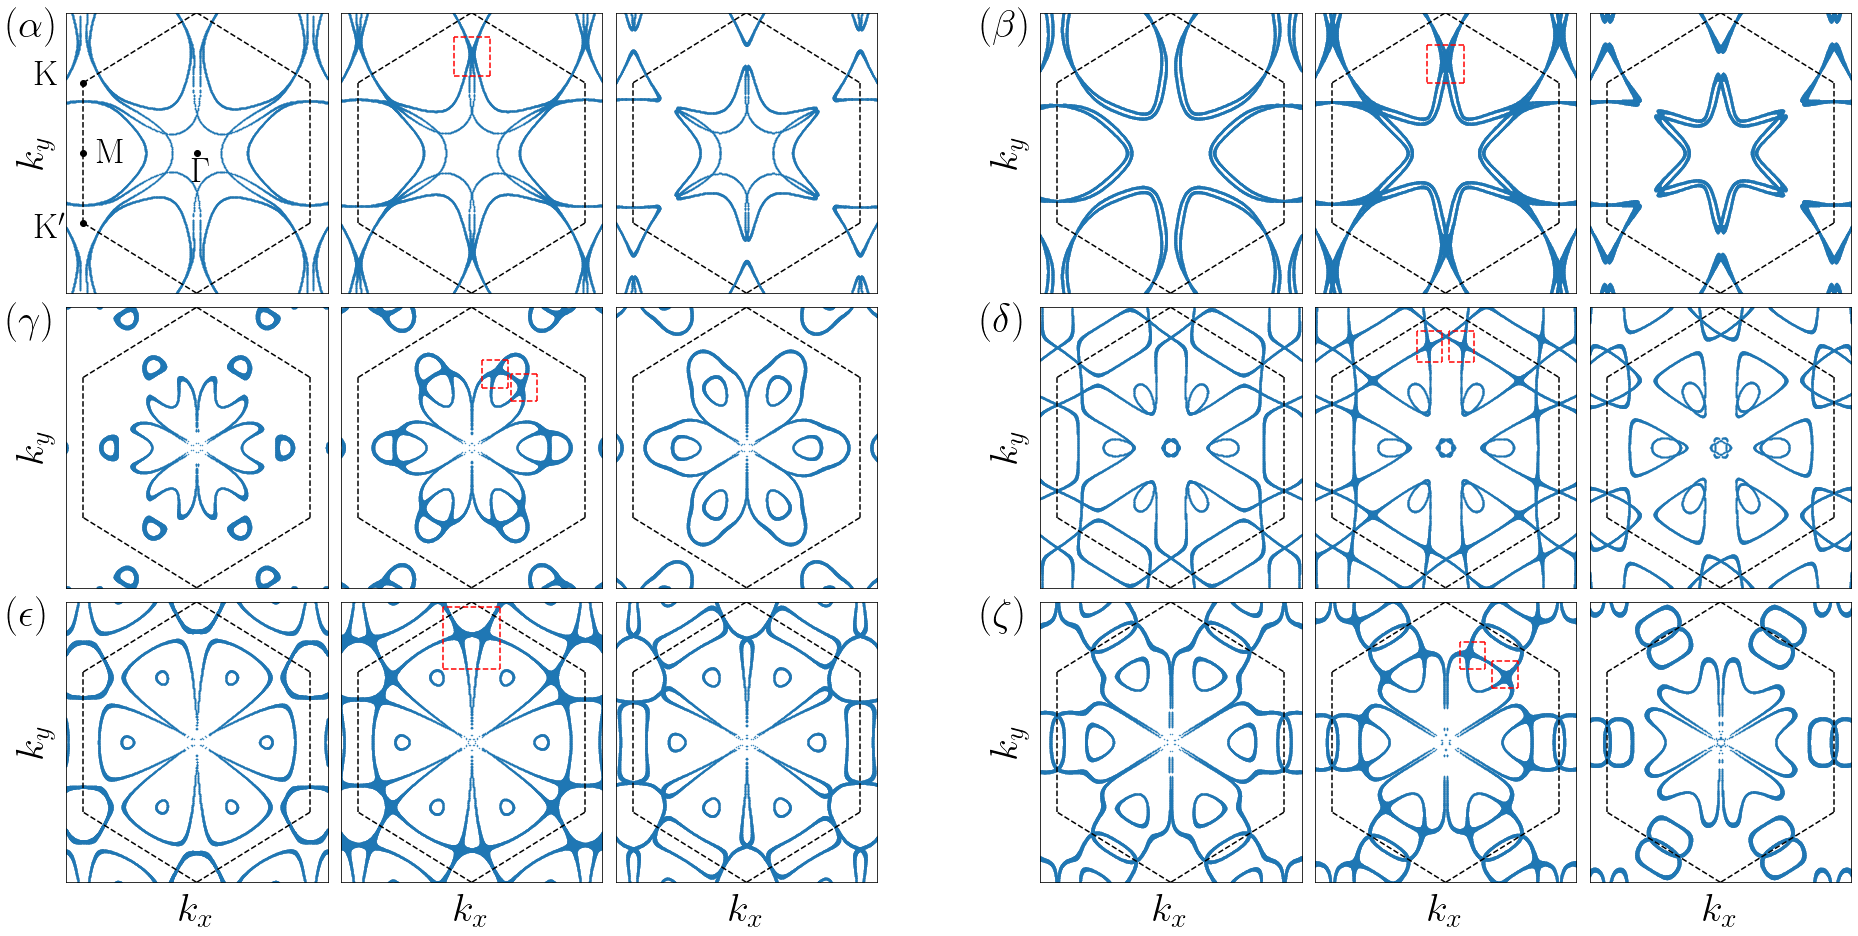

In [12]:
#*************************************************** Plotting ***************************************************#

plt.rcParams.update({'font.size': 40})
plt.rc('text', usetex=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(32, 16))

gs_outer = gridspec.GridSpec(1, 2,  figure=fig)

gs_left = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs_outer[0], wspace=0.05, hspace=0.05)
gs_right = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs_outer[1], wspace=0.05, hspace=0.05)

axs = {}

for i in range(3):
    for j in range(3):
        label = str(i+1) + str(j+1)
        ax = fig.add_subplot(gs_left[i,j])
        axs.update({label:ax})
        
for i in range(3):
    for j in range(3):
        label = str(i+1) + str(j+4)
        ax = fig.add_subplot(gs_right[i,j])
        axs.update({label:ax})
        

for i, label in enumerate(['11', '12', '13']):
    
    E = Energy_matrices[0]
    
    if label == '11':
        dE = 2e-2
        delta_E = -1e-1
    elif label == '12':
        dE = 2e-2
        delta_E = 0
    elif label == '13':
        dE = 2e-2
        delta_E = 0.5e-1
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_1_VHS[0] + delta_E)
    
      
for i, label in enumerate(['14', '15', '16']):
    
    E = Energy_matrices[1]
    
    if label == '14':
        dE = 2e-2
        delta_E = -0.75e-1
    elif label == '15':
        dE = 2e-2
        delta_E = 0
    elif label == '16':
        dE = 2e-2
        delta_E = 0.25e-1
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_2_VHS[0] + delta_E)
    
for i, label in enumerate(['21', '22', '23']):
    
    E = Energy_matrices[2]
    
    if label == '21':
        dE = 0.8e-2
        delta_E = -1e-2
    elif label == '22':
        dE = 0.8e-2
        delta_E = 0
    elif label == '23':
        dE = 0.8e-2
        delta_E = 1.5e-2
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_3_VHS[0] + delta_E)
        
for i, label in enumerate(['24', '25', '26']):
    
    E = Energy_matrices[2]
    
    if label == '24':
        dE = 0.8e-2
        delta_E = -1e-2
    elif label == '25':
        dE = 0.8e-2
        delta_E = 0
    elif label == '26':
        dE = 0.8e-2
        delta_E = 1.5e-2
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_3_VHS[1] + delta_E)
    
for i, label in enumerate(['31', '32', '33']):
    
    E = Energy_matrices[2]
    
    if label == '31':
        dE = 0.8e-2
        delta_E = -1e-2
    elif label == '32':
        dE = 0.8e-2
        delta_E = 0
    elif label == '33':
        dE = 0.8e-2
        delta_E = 1.5e-2
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_3_VHS[2] + delta_E)
        
for i, label in enumerate(['34', '35', '36']):
    
    E = Energy_matrices[2]
    
    if label == '34':
        dE = 0.8e-2
        delta_E = -1e-2
    elif label == '35':
        dE = 0.8e-2
        delta_E = 0
    elif label == '36':
        dE = 0.8e-2
        delta_E = 1.5e-2
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_3_VHS[3] + delta_E)
        
for label, counter in [('11',r'($\alpha$)'), ('14',r'($\beta$)'), ('21',r'($\gamma$)'), ('24',r'($\delta$)'),
                       ('31',r'($\epsilon$)'), ('34',r'($\zeta$)')]:
    
    axs[label].text( x = -5.25,y = 3, s = counter, fontsize = 40)
    
for label in ['11', '14', '21', '24', '31', '34']:
    
    axs[label].set_ylabel("$k_y$")
    
for label in ['31', '32', '33', '34', '35', '36']:
    
    axs[label].set_xlabel("$k_x$") 

axs['11'].plot([0, -k_D * np.cos(np.radians(30)), -k_D * np.cos(np.radians(30)), -k_D * np.cos(np.radians(30))],
               [0, k_D * np.sin(np.radians(30)), 0, -k_D * np.sin(np.radians(30))], 'ko')


axs['11'].text( x = -0.15,y = -0.75, s = '$\Gamma$', fontsize = 35)
axs['11'].text( x = -4.5,y = 1.75, s = '$\mathrm{K}$', fontsize = 35)
axs['11'].text( x = -2.8,y = -0.25, s = '$\mathrm{M}$', fontsize = 35)
axs['11'].text( x = -4.5,y = -2.2, s = '$\mathrm{K}\'$', fontsize = 35)


plot_red_box(axs['12'], [[-0.5,0.5],[2,3]])
plot_red_box(axs['15'], [[-0.5,0.5],[1.8,2.8]])

plot_red_box(axs['22'], [[0.3,1.0], [1.55,2.25]])
plot_red_box(axs['22'], [[1.1,1.8], [1.2,1.9]])

plot_red_box(axs['25'], [[-0.8,-0.1],[2.2,3.0]])
plot_red_box(axs['25'], [[0.1,0.8],[2.2,3.0]])


plot_red_box(axs['32'], [[-0.8,0.8],[1.9,3.5]])
plot_red_box(axs['35'], [[0.4,1.1], [1.9,2.6]])
plot_red_box(axs['35'], [[1.3,2.0], [1.4,2.1]])


plt.savefig(figure_dir + 'fig5.png')
plt.show()
plt.close()

# Figure S1: Fermi surfaces at crossing points which are not van Hove singularities

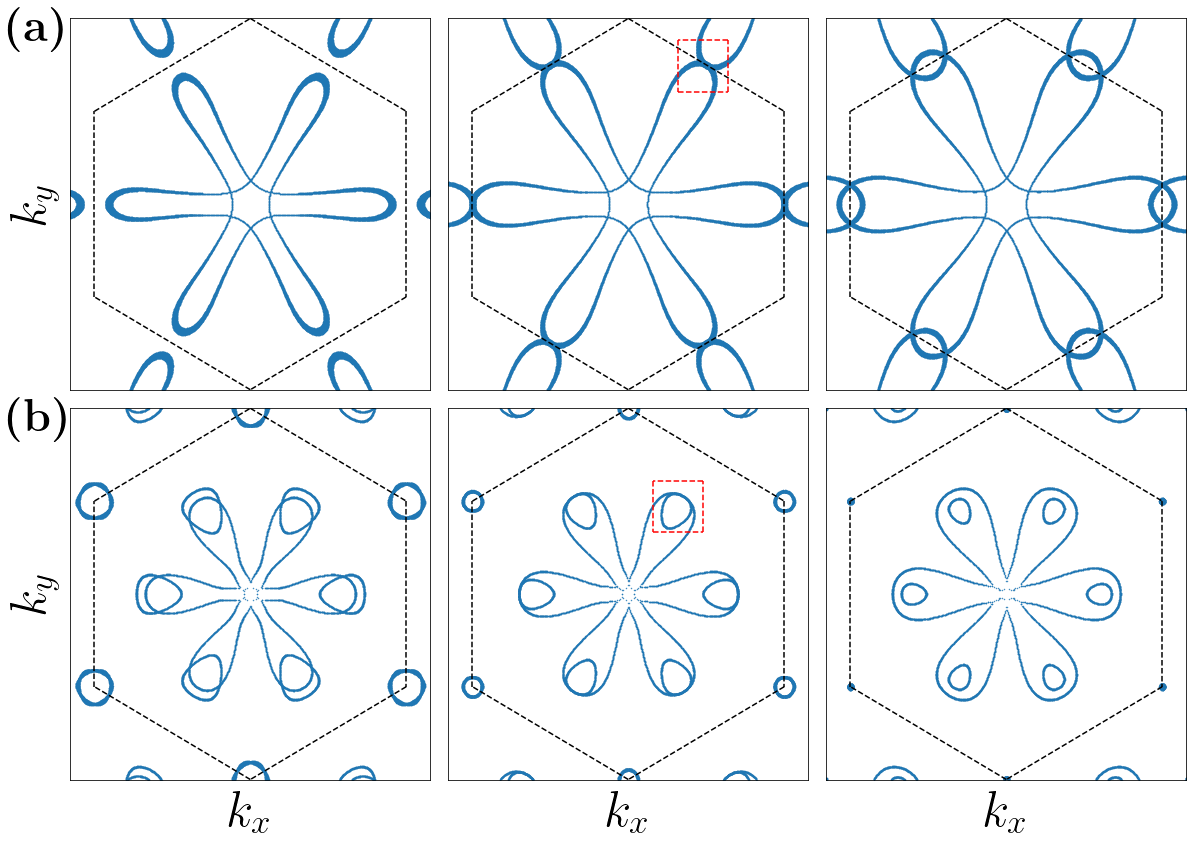

In [13]:

#*************************************************** Plotting ***************************************************#


plt.rcParams.update({'font.size': 50})
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(20, 14))

gs_outer = gridspec.GridSpec(2, 1,  figure=fig, hspace = 0.05)

gs_top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_outer[0], wspace=0.05, hspace=0.)
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_outer[1], wspace=0.05, hspace=0.)

axs = {}

for i in range(3):
    label = str(i+1)
    ax = fig.add_subplot(gs_top[0,i])
    axs.update({label:ax})
        
for i in range(3):
    label = str(i+4)
    ax = fig.add_subplot(gs_bottom[0,i])
    axs.update({label:ax})
    
for i, label in enumerate(['1', '2', '3']):
    
    E = Energy_matrices[0]
        
    if label == '1':
        dE = 1e-1
        delta_E = -2.5e-1
        
    elif label == '2':
        dE = 1e-1
        delta_E = 0
        
    elif label == '3':
        dE = 1e-1
        delta_E = 2.5e-1
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_1_crossings[0] + delta_E)
    
    
for i, label in enumerate(['4', '5', '6']):
    
    E = Energy_matrices[2]
        
    if label == '4':
        dE = 1e-2
        delta_E = -0.5e-1
        
    elif label == '5':
        dE = 1e-2
        delta_E = 0
        
    elif label == '6':
        dE = 1e-2
        delta_E = 0.5e-1
        
    plot_fermi_surface(axs[label], X, Y, E, dE, column_3_crossings[1] + delta_E)

for label, ax in axs.items():
        
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    

for label, counter in [('1',r'$\textbf{(a)}$ '), ('4',r'$\textbf{(b)}$ ')]:
    
    axs[label].text( x = -4.9,y = 3.2, s = counter, fontsize = 45)
    
for label in ['1', '4']:
    
    axs[label].set_ylabel("$k_y$")
    
for label in ['4', '5', '6']:
    
    axs[label].set_xlabel("$k_x$")
    
k_box_coords1 = [[1, 2], [2.2, 3.2]]
k_box_coords2 = [[0.5, 1.5], [1.2, 2.2]]

plot_red_box(axs['2'], k_box_coords1)
plot_red_box(axs['5'], k_box_coords2)
    
plt.savefig(figure_dir + 'fig6.png')
plt.show()
plt.close()

# Figure S2: Effect of system size on low-energy conductance

In [14]:
#******************************************* Locating the files path *******************************************#

size_data_dir = data_dir + '/Conductance/Lattice size dependance/'

size_1 = "300x120"
size_2 = "600x100"
size_3 = "600x110"
size_4 = "600x120"

#********************************************* Extracting the data ********************************************#

energies_1 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_1 + '/energies.npy')
energies_2 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_2 + '/energies.npy')
energies_3 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_3 + '/energies.npy')
energies_4 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_4 + '/energies.npy')

#******* Conductance matrices ********#

Gs_1 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_1 + '/conductance_matrices.npy')
Gs_2 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_2 + '/conductance_matrices.npy')
Gs_3 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_3 + '/conductance_matrices.npy')
Gs_4 =np.load(size_data_dir + 'theta=1.02_Vpps=0.390/' + size_4 + '/conductance_matrices.npy')



#***************************************** Extracting the conductances ******************************************#

G12s_1 = []
G12s_2 = []
G12s_3 = []
G12s_4 = []


for i in range(len(Gs_1)):
    G12s_1.append(-Gs_1[i][1,2])
    
for i in range(len(Gs_2)):
    G12s_2.append(-Gs_2[i][1,2])

for i in range(len(Gs_3)):
    G12s_3.append(-Gs_3[i][1,2])
    
for i in range(len(Gs_4)):
    G12s_4.append(-Gs_4[i][1,2])

    
#****************************************** Converting the sizes to nm ******************************************#


size_nm_1 = r"{:.0f}$\times${:.0f}".format(int(size_1[0:3])* R0 / 10 , int(size_1[4:7]) * R0 / 10) + r" $\mathrm{nm}$"
size_nm_2 = r"{:.0f}$\times${:.0f}".format(int(size_2[0:3])* R0 / 10 , int(size_2[4:7]) * R0 / 10) + r" $\mathrm{nm}$"
size_nm_3 = r"{:.0f}$\times${:.0f}".format(int(size_3[0:3])* R0 / 10 , int(size_3[4:7]) * R0 / 10) + r" $\mathrm{nm}$"
size_nm_4 = r"{:.0f}$\times${:.0f}".format(int(size_4[0:3])* R0 / 10 , int(size_4[4:7]) * R0 / 10) + r" $\mathrm{nm}$"


#*************************** Converting energy to meV and fixing Fermi level at E = 0 ***************************#

spec_dir = data_dir + '/Spectrum'
energies_linear_spectrum = np.load(spec_dir + '/theta=1.02_Vpps=0.390/' +  'linear_energies.npy')
fermi_level = sum(energies_linear_spectrum[0][0:4]) / 4
for energies_array in [energies_1, energies_2, energies_3, energies_4]:
    for i, energy in enumerate(energies_array):
        energies_array[i] = (energy - fermi_level) * 1000 


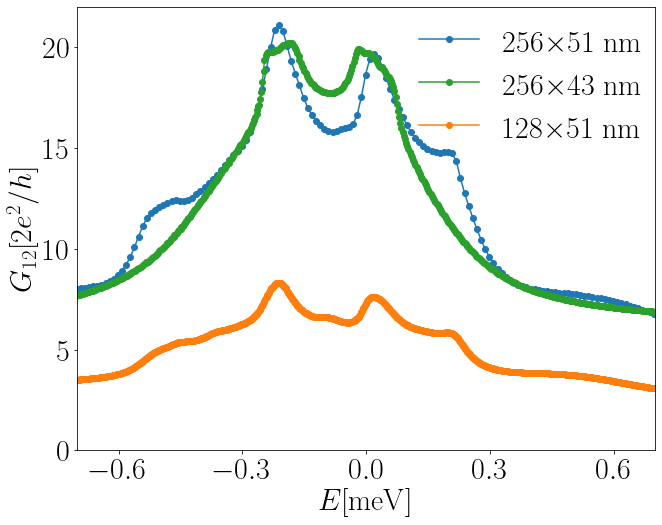

In [15]:
#*************************************************** Plotting ***************************************************#

plt.rcParams.update({'font.size': 30})
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig,ax1 = plt.subplots(figsize = (10,8))

ax1.plot(energies_4,G12s_4,marker = 'o', label =  size_nm_4, c = colors[0])
ax1.plot(energies_2,G12s_2,marker = 'o', label =  size_nm_2,c = colors[2])
ax1.plot(energies_1,G12s_1,marker = 'o', label =  size_nm_1, c = colors[1])

#ax1.plot(sizes_nm_3, np.array(G12s_3) * 2,ls = '--', c = 'k')

ax1.set_ylim(0,22)
ax1.set_xlim(- 0.7, 0.7)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel("$E [\mathrm{meV}]$")
ax1.set_ylabel("$G_{12} [2 e^2 / h]$")
ax1.legend(loc = (0.57, 0.67), frameon = False)

# ax3 = ax1.twiny()
# ax3.plot(np.array(sizes_nm_1) / 5, G12s_1,marker = 'o',  c = colors[0])
# ax3.plot(np.array(sizes_nm_2) / 5, G12s_2,marker = 'o',  c = colors[1])
# ax3.plot(np.array(sizes_nm_3) / 5, G12s_3,marker = 'o',  c = colors[2])
# ax3.plot(np.array(sizes_nm_4) / 5, G12s_4,marker = 'o',  c = colors[3])

# ax3.yaxis.set_major_locator(plt.MaxNLocator(5))
# ax3.xaxis.set_major_locator(plt.MaxNLocator(5))
# ax3.set_xlabel(r"$W_{bottom}$" + "[nm]",labelpad=10)
#ax3.set_xlim((min(sizes_nm_1) - 1) / 5, (max(sizes_nm_1) + 1) / 5)
#ax3.set_ylim(0,16)

plt.tight_layout()
plt.savefig(figure_dir + 'fig7.pdf')
plt.show()
plt.close()


# Supplementary: Flat band and DOS evolution GIF

In [16]:
#*********************************** Loading the energy and K_x, K_y matrices ***********************************#

spectrum_dir = data_dir + '/Spectrum/'
dos_dir = data_dir + '/DOS/'

X = np.load(spectrum_dir + "Area matrices Kx, Ky.npz")['Kx']
Y = np.load(spectrum_dir + "Area matrices Kx, Ky.npz")['Ky']

angles_ev = [1.16, 1.12, 1.08, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05, 1.05]
hops_ev = [0.390, 0.390, 0.390, 0.387, 0.390, 0.393, 0.395, 0.396, 0.398, 0.400, 0.403]

dos_energies = []
dos_N_states = []
Energy_matrices_ev = []
linear_spectrum_ev = []

for i in range(len(angles_ev)):

    E_temp = np.load(spectrum_dir + 'theta={:.2f}_Vpps={:.3f}/Energies_matrix.npy'.format(angles_ev[i],hops_ev[i]))
    linear_spectrum_temp = np.load(spectrum_dir + 'theta={:.2f}_Vpps={:.3f}/linear_energies.npy'.format(angles_ev[i],hops_ev[i]))
    dos_energies_temp = np.load(dos_dir + 'theta={:.2f}_Vpps={:.3f}/energies.npy'.format(angles_ev[i],hops_ev[i]))
    dos_N_states_temp = np.load(dos_dir + 'theta={:.2f}_Vpps={:.3f}/N_states.npy'.format(angles_ev[i],hops_ev[i]))
    
#*********************** Converting the energy to meV and fixing the Fermi level to E = 0 ***********************#


    linear_spectrum_temp = np.array(linear_spectrum_temp) * 1000
    fermi_level_temp = sum(linear_spectrum_temp[0][0:4]) / 4
    linear_spectrum_temp += -fermi_level_temp
    
    E_temp = np.array(E_temp) * 1000
    E_temp += -fermi_level_temp
    
    dos_energies_temp = np.array(dos_energies_temp) * 1000 - fermi_level_temp
    dos_N_states_temp = np.array(dos_N_states_temp) / sum(dos_N_states_temp)

    
    Energy_matrices_ev.append(E_temp)
    linear_spectrum_ev.append(linear_spectrum_temp)
    dos_energies.append(dos_energies_temp)
    dos_N_states.append(dos_N_states_temp)
    



In [17]:
def plotter_gif(indeks, dE_array, delta_E_matrix, VHS_labels = None, 
                label_positions = None, k_box_coords_array = None, filename = None):
    '''
        Plots one frame for the gif animation. 
    '''
    
    E = Energy_matrices_ev[indeks]
    linear_spectrum = linear_spectrum_ev[indeks]
    N = len(linear_spectrum)

    
    plt.rcParams.update({'font.size': 40})
    plt.rcParams['font.family'] = 'serif'
    plt.rc('text', usetex=True)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    fig = plt.figure(figsize=(30, 20))

    gs_outer = gridspec.GridSpec(1, 2,  figure=fig, wspace= 0.10, hspace=None)


    gs_left = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_outer[0], wspace=0.05, hspace=0.05)
    gs_right = gridspec.GridSpecFromSubplotSpec(4, 3, subplot_spec=gs_outer[1], wspace=0.05, hspace=0.05)

    axs = {}


    for i in range(2):
        label = 'L' + str(i+1)
        if i == 0:    
            ax = fig.add_subplot(gs_left[i])
        else:
            ax = fig.add_subplot(gs_left[1:3])
        axs.update({label:ax})


    for i in range(4):
        for j in range(3):
            label = 'R' + str(i+1) + str(j+1)
            ax = fig.add_subplot(gs_right[i,j])
            axs.update({label:ax})



    for label, ax in axs.items():

        if label != 'L2':
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([], minor=True)
            ax.set_yticks([], minor=True)
            ax.xaxis.set_ticks_position('none') 
            ax.yaxis.set_ticks_position('none') 

    axs['L1'].set_ylabel("$\mathrm{DOS}$")
    axs['L2'].set_xlabel("$E [\mathrm{meV}]$")

    for label in ['R11', 'R21', 'R31', 'R41']:

        axs[label].set_ylabel("$k_y$")

    for label in ['R41', 'R42', 'R43']:

        axs[label].set_xlabel("$k_x$")
        
    #************************************************* Plotting DOS *************************************************#       
    
    for i in range(4):
        if VHSindeces_3[indeks] is not None:
            peak_indexes = (VHSindeces_1[indeks], VHSindeces_2[indeks], VHSindeces_3[indeks], VHSindeces_4[indeks])
        else:
            peak_indexes = (VHSindeces_1[indeks], VHSindeces_2[indeks], VHSindeces_4[indeks])
            
        
    axs['L1'].set_xlim(E_ranges[indeks])
    axs['L1'].set_ylim((0, max(dos_N_states[indeks])))
        
    axs['L1'].plot(dos_energies[indeks], dos_N_states[indeks], marker = 'o', color = colors[0], markersize=0.1)
    
    for i in peak_indexes:
        axs['L1'].vlines(dos_energies[indeks][i], ymin = 0, ymax = 1, ls ='dashed', lw = 1, color = 'r')
    

    #******************************************* Plotting linear spectrum *******************************************#
    
    Ns = np.linspace(0, N, N )

    axs['L2'].set_xlim(E_ranges[indeks])
    axs['L2'].set_ylim([0,N])
    axs['L2'].xaxis.set_major_locator(plt.MaxNLocator(3))
    
    axs['L2'].set_yticks([0, N / (1+cos_30+sin_30), N * (1+cos_30) / (1+cos_30+sin_30), N])   
    axs['L2'].set_xlabel("$E [\mathrm{meV}]$")
    axs['L2'].hlines([0, N / (1+cos_30+sin_30), N * (1+cos_30) / (1+cos_30+sin_30), N],
                      xmin = E_ranges[indeks][0], xmax = E_ranges[indeks][1],ls ='dashed',lw = 1, color = 'k')
    axs['L2'].tick_params(direction='in', right=False, top=False)
    axs['L2'].set_yticklabels(['$\mathrm{K}$','$\Gamma$','$\mathrm{M}$','$\mathrm{K}\'$'])

    for i in peak_indexes:
        axs['L2'].vlines(dos_energies[indeks][i], ymin = 0, ymax = N, ls ='dashed', lw = 1, color = 'r')
              
    axs['L2'].plot(linear_spectrum, Ns, color = colors[0])
    
        
    #******************************************* Plotting Fermi surfaces *******************************************#   

    for i, label in enumerate(['R11', 'R12', 'R13']):
    
        if dE_array[0] == None:
            break
            
        if label == 'R11':
            delta_E = delta_E_matrix[0][0]

        elif label == 'R12':
            delta_E = delta_E_matrix[0][1]

        elif label == 'R13':
            delta_E = delta_E_matrix[0][2]
        
        plot_fermi_surface(axs[label], X, Y, E, dE_array[0], dos_energies[indeks][VHSindeces_1[indeks]] + delta_E)
        
    for i, label in enumerate(['R21', 'R22', 'R23']):

        if dE_array[3] == None:
            break
            
        if label == 'R21':
            delta_E = delta_E_matrix[3][0]

        elif label == 'R22':
            delta_E = delta_E_matrix[3][1]

        elif label == 'R23':
            delta_E = delta_E_matrix[3][2]

        plot_fermi_surface(axs[label], X, Y, E, dE_array[3], dos_energies[indeks][VHSindeces_4[indeks]] + delta_E)

    for i, label in enumerate(['R31', 'R32', 'R33']):

        if dE_array[1] == None:
            break
            
        if label == 'R31':
            delta_E = delta_E_matrix[1][0]

        elif label == 'R32':
            delta_E = delta_E_matrix[1][1]

        elif label == 'R33':
            delta_E = delta_E_matrix[1][2]

        plot_fermi_surface(axs[label], X, Y, E, dE_array[1], dos_energies[indeks][VHSindeces_2[indeks]] + delta_E)
        

    for i, label in enumerate(['R41', 'R42', 'R43']):

        if dE_array[2] == None:
            break

        if label == 'R41':
            delta_E = delta_E_matrix[2][0]

        elif label == 'R42':
            delta_E = delta_E_matrix[2][1]

        elif label == 'R43':
            delta_E = delta_E_matrix[2][2]

        plot_fermi_surface(axs[label], X, Y, E, dE_array[2], dos_energies[indeks][VHSindeces_3[indeks]] + delta_E)
        
        
    if k_box_coords_array is not None:
        
        if k_box_coords_array[3] is not None:
            
            for i, label in enumerate(['R12', 'R22', 'R32', 'R42']):

                plot_red_box(axs[label], k_box_coords_array[i])
                    
        else:
            
            for i, label in enumerate(['R12', 'R22', 'R32']):

                plot_red_box(axs[label], k_box_coords_array[i])


    # ******************** adding text ***************************
    
    if VHS_labels is not None:
        for i in range(len(VHS_labels)):
            axs['L1'].text(x = label_positions[i][0],y = label_positions[i][1], s = VHS_labels[i], fontsize = 40)
            axs['R{}1'.format(i + 1)].text(x = -5,y = 2.8, s = '(' + VHS_labels[i] + ')', fontsize = 40)
        
    plot_title = r'$\theta$ ' + "= {:.2f}".format(angles_ev[indeks]) \
               + r"$^\circ ;$" + r" $\mathrm{V}_{pp\sigma}^0$" + " = {:.0f}".format(hops_ev[indeks] * 1000) + r"$\mathrm{meV}$"
        
    fig.suptitle(plot_title, fontsize=40, y = 0.93)
    
    if filename is not None:
        plt.savefig(figure_dir + filename)
        
    plt.show()
    plt.close()

In [29]:
#************************************** Defining parameters for the plots: **************************************#

#********************************** Indeces were VHSs are located ***********************************#

VHSindeces_1 = [425, 1576, 420, 410, 333, 467, 501, 515, 461, 1078, 129]
VHSindeces_2 = [430, 1602, 436, 443, 377, 574, 584, 621, 544, 1196, 231]
VHSindeces_3 = [495, 1727, 467, 468, 390, None, 501, 504, 434, 1016, 52]
VHSindeces_4 = [500, 1765, 498, 547, 484, 641, 611, 645, 548, 1189, 214]

#************************ Energy ranges for the DOS and linear spectrum plots ************************#

E_ranges = ((-10,10), (-5,5), (-3,3), (-2,2), (-1.5,1.5), (-1.25, 1.25), (-1.25, 1.25), (-1.25,1.25), (-1.25, 1.25), (-0.8,0.8), (-0.75,0.75))

#***************************** dE and delta E for the Fermi surface plots *****************************#

dE1 = [2e-2, 2e-2, 2e-2, 2e-2]
delta_E1 = [[-0.5e-1, 0, 0.5e-1], [-2e-2, 0, 2e-2], [-3e-2, 1e-2, 4e-2], [-4e-2, 0.8e-2, 5e-2]]

dE2 = [2.5e-2, 2.5e-2, 2.5e-2, 2.5e-2]
delta_E2 = [[-5e-2, 0, 5e-2], [-5e-2, 0, 4e-2], [-4e-2, 0, 5e-2], [-5e-2, 0, 5e-2]]

dE3 = [2.5e-2, 2.5e-2, 2.5e-2, 2.5e-2]
delta_E3 = [[-5e-2, 0, 4e-2], [-3e-2, 1e-2, 5e-2], [-3e-2, 0, 4e-2], [-5e-2, 0, 3e-2]]

dE4 = [1e-2, 1.5e-2, 1e-2, 1e-2]
delta_E4 = [[-5e-2, 0, 3e-2], [-5e-2, 0, 2e-2], [-1.25e-2, 0, 1e-2], [-1e-2, 0, 1e-2]]

dE5 = [1e-2, 1e-2, 1e-2, 1e-2]
delta_E5 = [[-2e-2, 0, 2e-2], [-1e-2, 0, 1e-2], [-1.25e-2, 0, 1e-2], [-1e-2, 0, 1e-2]]

dE6 = [1e-2, 1e-2, None, 1e-2]
delta_E6 = [[-1.5e-2, 0, 1e-2], [-1.5e-2, 0, 0.75e-2], None, [-1e-2, 0, 1e-2]]

dE7 = [1e-2, 1e-2, 1e-2, 1e-2]
delta_E7 = [[-1e-2, 0, 1e-2], [-1e-2, 0, 1e-2], [-1e-2, 0, 1e-2], [-1e-2, 0, 1e-2]]

dE8 = [1.5e-2, 1.5e-2, 1.5e-2, 0.75e-2]
delta_E8 = [[-2e-2, 0, 2e-2], [-1e-2, 0, 1e-2], [-2e-2, 0, 2e-2], [-1e-2, 0, 1e-2]]

dE9 = [1.5e-2, 1e-2, 1.5e-2, 0.75e-2]
delta_E9 = [[-2e-2, 0, 2e-2], [-1e-2, 0, 1e-2], [-2e-2, 0, 2e-2], [-1e-2, 0, 1e-2]]

dE10 = [1.5e-2, 1e-2, 1e-2, 0.75e-2]
delta_E10 = [[-2e-2, 0, 2e-2], [-1e-2, 0, 1e-2], [-0.75e-2, 0, 1e-2], [-1e-2, 0, 1e-2]]

dE11 = [1.5e-2, 1e-2, 1e-2, 1e-2]
delta_E11 = [[-1.5e-2, 0, 1.5e-2], [-1e-2, 0, 1e-2], [-0.75e-2, 0, 0.75e-2], [-1e-2, 0, 1e-2]]

dEs = []
delta_Es = []

for i in range(11):
    dEs.append(globals()['dE{}'.format(i+1)])
    delta_Es.append(globals()['delta_E{}'.format(i+1)])
    
#********************************* Labels and position of the labels *********************************#

VHS_labels_matrix = []
label_positions_matrix = []

VHS_labels1 = [r'$\alpha$', r'$\epsilon$', r'$\eta$', r'$\lambda$']
label_positions1 = [(-2.2, 0.0118), (1.75, 0.0118), (-0.95, 0.0118), (0.7, 0.0118)]

VHS_labels2 = [r'$\alpha$', r'$\epsilon$', r'$\eta$', r'$\lambda$']
label_positions2 = [(-1.3, 0.00415), (0.85, 0.00415), (-0.65, 0.00415), (0.4, 0.00415)]

VHS_labels3 = [r'$\alpha$', r'$\epsilon$', r'$\eta$', r'$\lambda$']
label_positions3 = [(-0.75, 0.0082), (0.55, 0.0082), (-0.45, 0.0082), (0.03, 0.0082)]

VHS_labels4 = [r'$\alpha$', r'$\epsilon$', r'$\eta$', r'$\lambda$']
label_positions4 = [(-0.55, 0.0056), (0.35, 0.0056), (-0.3, 0.0056), (-0.13, 0.0056)]

VHS_labels5 = [r'$\alpha$', r'$\epsilon$', r'$\eta$', r'$\lambda$']
label_positions5 = [(-0.48, 0.0058), (0.30, 0.0058), (-0.225, 0.0058), (-0.12, 0.0058)]

VHS_labels6 = [r'$\alpha$', r'$\epsilon$', r'$\zeta$']
label_positions6 = [(-0.45, 0.0062), (0.27, 0.0062), (-0.01, 0.0062)]

VHS_labels7 = [r'$\alpha$', r'$\epsilon$', r'$\zeta$', r'$\gamma$']
label_positions7 = [(-0.37, 0.00975), (0.25, 0.00975), (0.075, 0.00975), (-0.5, 0.00975)]

VHS_labels8 = [r'$\alpha$', r'$\epsilon$', r'$\zeta$', r'$\gamma$']
label_positions8 = [(-0.420, 0.0095), (0.25, 0.0095), (0.115, 0.0095), (-0.5, 0.0095)]

VHS_labels9 = [r'$\alpha$', r'$\epsilon$', r'$\zeta$', r'$\gamma$']
label_positions9 = [(-0.38, 0.021), (0.25, 0.021), (0.18, 0.021), (-0.58, 0.021)]

VHS_labels10 = [r'$\alpha$', r'$\epsilon$', r'$\zeta$', r'$\gamma$']
label_positions10 = [(-0.33, 0.0167), (0.22, 0.0167), (0.27, 0.0167), (-0.65, 0.0167)]

VHS_labels11 = [r'$\alpha$', r'$\epsilon$', r'$\zeta$', r'$\gamma$']
label_positions11 = [(-0.27, 0.016), (0.17, 0.016), (0.25, 0.016), (-0.66, 0.016)]

for VHS_label, label_pos in ((VHS_labels1, label_positions1), (VHS_labels2, label_positions2), (VHS_labels3, label_positions3),
                             (VHS_labels4, label_positions4), (VHS_labels5, label_positions5), (VHS_labels6, label_positions6),
                             (VHS_labels7, label_positions7), (VHS_labels8, label_positions8), (VHS_labels9, label_positions9),
                             (VHS_labels10, label_positions10), (VHS_labels11, label_positions11)):

    VHS_labels_matrix.append(VHS_label)
    label_positions_matrix.append(label_pos)
    
#************************************ Coordinates of the red boxes ************************************#

k_box_coords_1_VHS1 = [[-0.5, 0.5], [2, 3]]
k_box_coords_1_VHS2 = [[0.1, 1.1], [0.5, 1.5]]
k_box_coords_1_VHS3 = [[0.1, 1.1], [0.5, 1.5]]
k_box_coords_1_VHS4 = [[-0.5, 0.5], [2, 3]]

k_box_coords_2_VHS1 = [[-0.5, 0.5], [2, 3]]
k_box_coords_2_VHS2 = [[0.0, 1.0], [0.35, 1.35]]
k_box_coords_2_VHS3 = [[0.0, 1.0], [0.35, 1.35]]
k_box_coords_2_VHS4 = [[-0.5, 0.5], [2.15, 3.15]]

k_box_coords_3_VHS1 = [[-0.5, 0.5], [2, 3]]
k_box_coords_3_VHS2 = [[-0.1, 0.9], [0.15, 1.15]]
k_box_coords_3_VHS3 = [[-0.1, 0.9], [0.15, 1.15]]
k_box_coords_3_VHS4 = [[-0.5, 0.5], [2.25, 3.25]]

k_box_coords_4_VHS1 = [[-0.5, 0.5], [2, 3]]
k_box_coords_4_VHS2 = [[0.0, 0.6], [0.2, 0.8]]
k_box_coords_4_VHS3 = [[0.0, 0.6], [0.2, 0.8]]
k_box_coords_4_VHS4 = [[-0.5, 0.5], [2.2, 3.2]]

k_box_coords_5_VHS1 = [[-0.5, 0.5], [1.8, 2.8]]
k_box_coords_5_VHS2 = [[0.0, 0.6], [0.0, 0.6]]
k_box_coords_5_VHS3 = [[0.0, 0.6], [0.1, 0.7]]
k_box_coords_5_VHS4 = [[-0.5, 0.5], [2.2, 3.2]]

k_box_coords_6_VHS1 = [[-0.5, 0.5], [1.8, 2.8]]
k_box_coords_6_VHS2 = [[-0.3, 0.3], [0.5, 1.1]]
k_box_coords_6_VHS3 = None
k_box_coords_6_VHS4 = [[-0.5, 0.5], [2.1, 3.1]]

k_box_coords_7_VHS1 = [[-0.5, 0.5], [1.75, 2.75]]
k_box_coords_7_VHS2 = [[-0.5, 0.5], [0.5, 1.5]]
k_box_coords_7_VHS3 = [[-0.5, 0.5], [1.8, 2.8]]
k_box_coords_7_VHS4 = [[-0.5, 0.5], [2.0, 3.0]]

k_box_coords_8_VHS1 = [[-0.5, 0.5], [1.7, 2.7]]
k_box_coords_8_VHS2 = [[-0.5, 0.5], [0.5, 1.5]]
k_box_coords_8_VHS3 = [[0., 0.8], [0.3, 1.1]]
k_box_coords_8_VHS4 = [[-0.5, 0.5], [2.0, 3.0]]

k_box_coords_9_VHS1 = [[-0.7, 0.7], [1.6, 3.0]]
k_box_coords_9_VHS2 = [[-0.5, 0.5], [0.85, 1.85]]
k_box_coords_9_VHS3 = [[-0.6, 0.6], [0.4, 1.6]]
k_box_coords_9_VHS4 = [[-0.5, 0.5], [1.8, 2.8]]

k_box_coords_10_VHS1 = [[-0.8, 0.8], [1.7, 3.3]]
k_box_coords_10_VHS2 = [[-0.7, 0.7], [1.1, 2.5]]
k_box_coords_10_VHS3 = [[-0.7, 0.7], [0.6, 2.0]]
k_box_coords_10_VHS4 = [[-0.5, 0.5], [2, 3]]

k_box_coords_11_VHS1 = [[-1.0, 1.0], [1.8, 3.6]]
k_box_coords_11_VHS2 = [[0.4, 2.0], [1.1, 2.7]]
k_box_coords_11_VHS3 = [[0.5, 1.7], [1.2, 2.4]]
k_box_coords_11_VHS4 = [[-1.0, 1.0], [1.8, 3.6]]

k_box_coords_matrix = []

for i in range(11):
    k_box_coords_matrix.append([])
    for j in (1,4,2,3):
        k_box_coords_matrix[i].append(globals()['k_box_coords_{}_VHS{}'.format(i+1,j)])

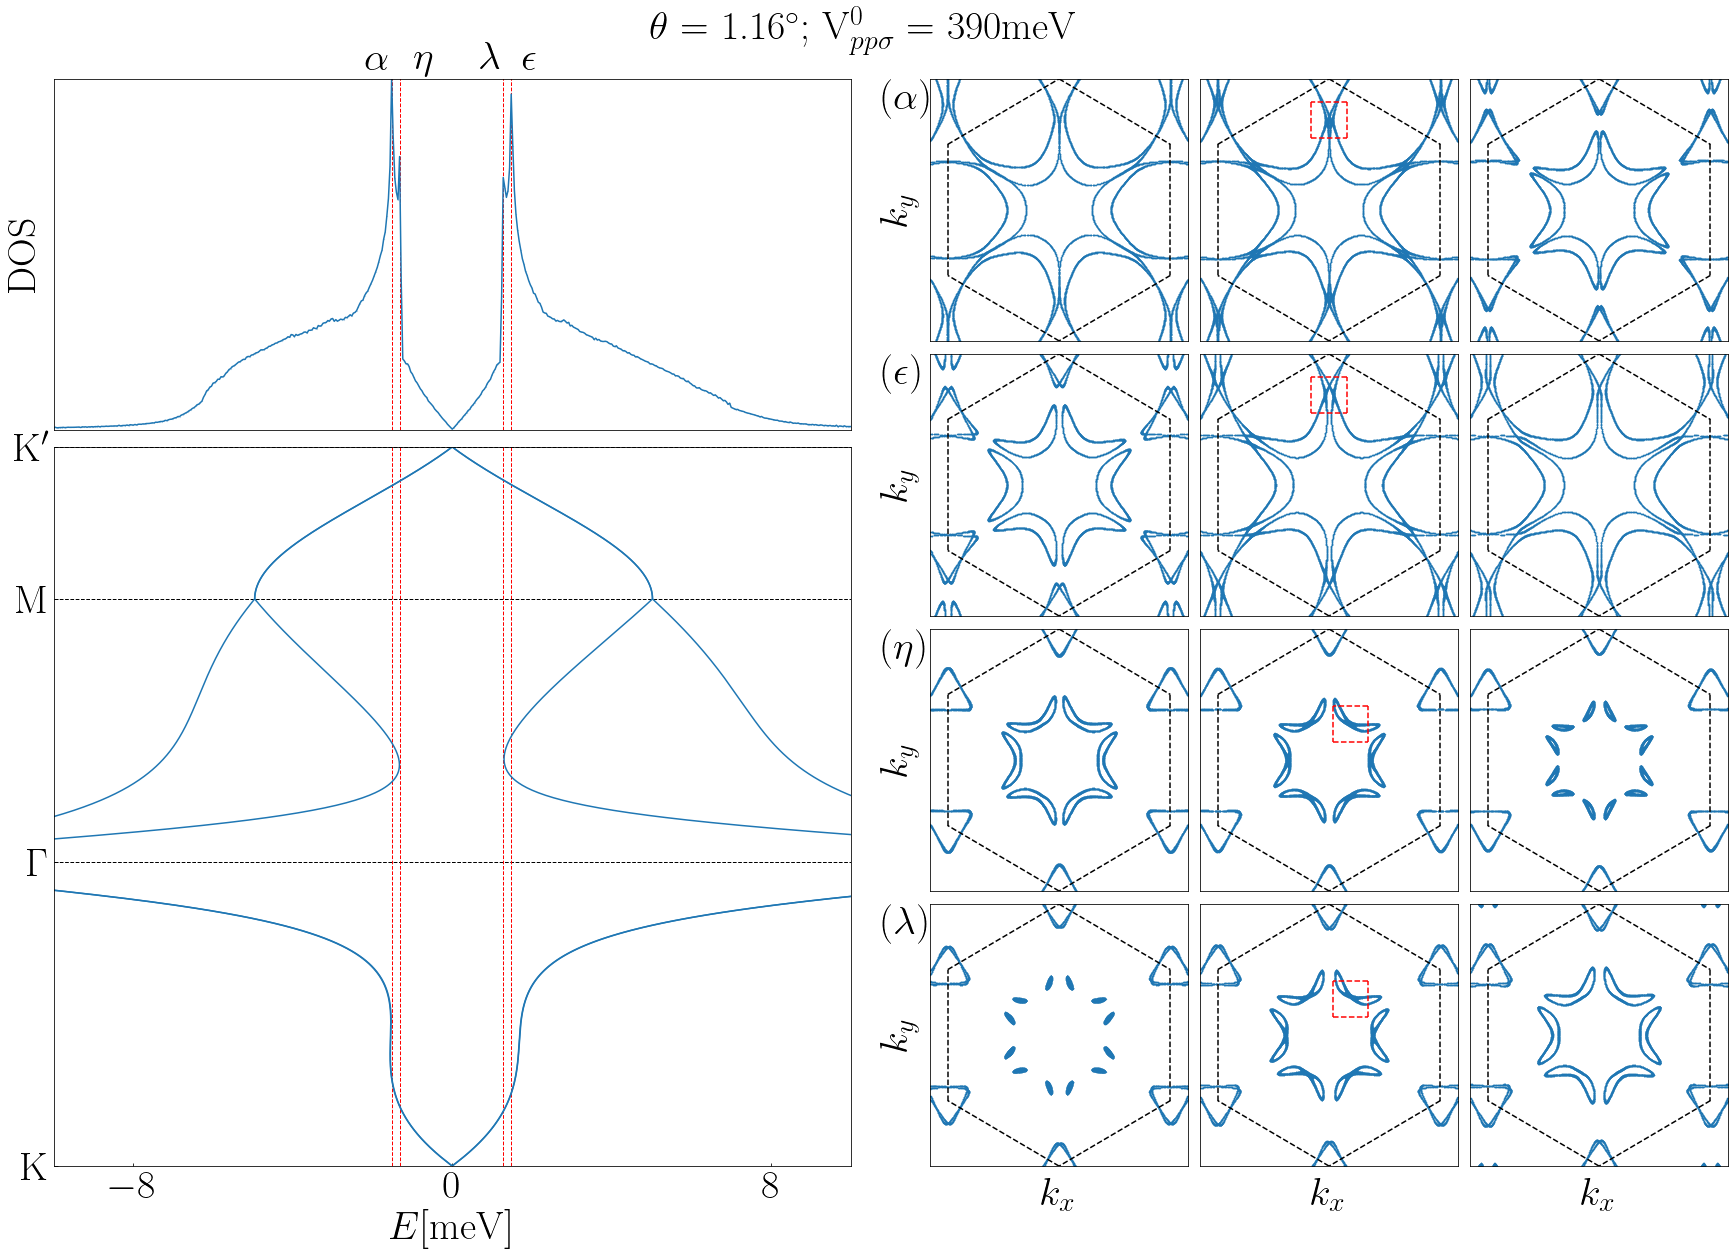

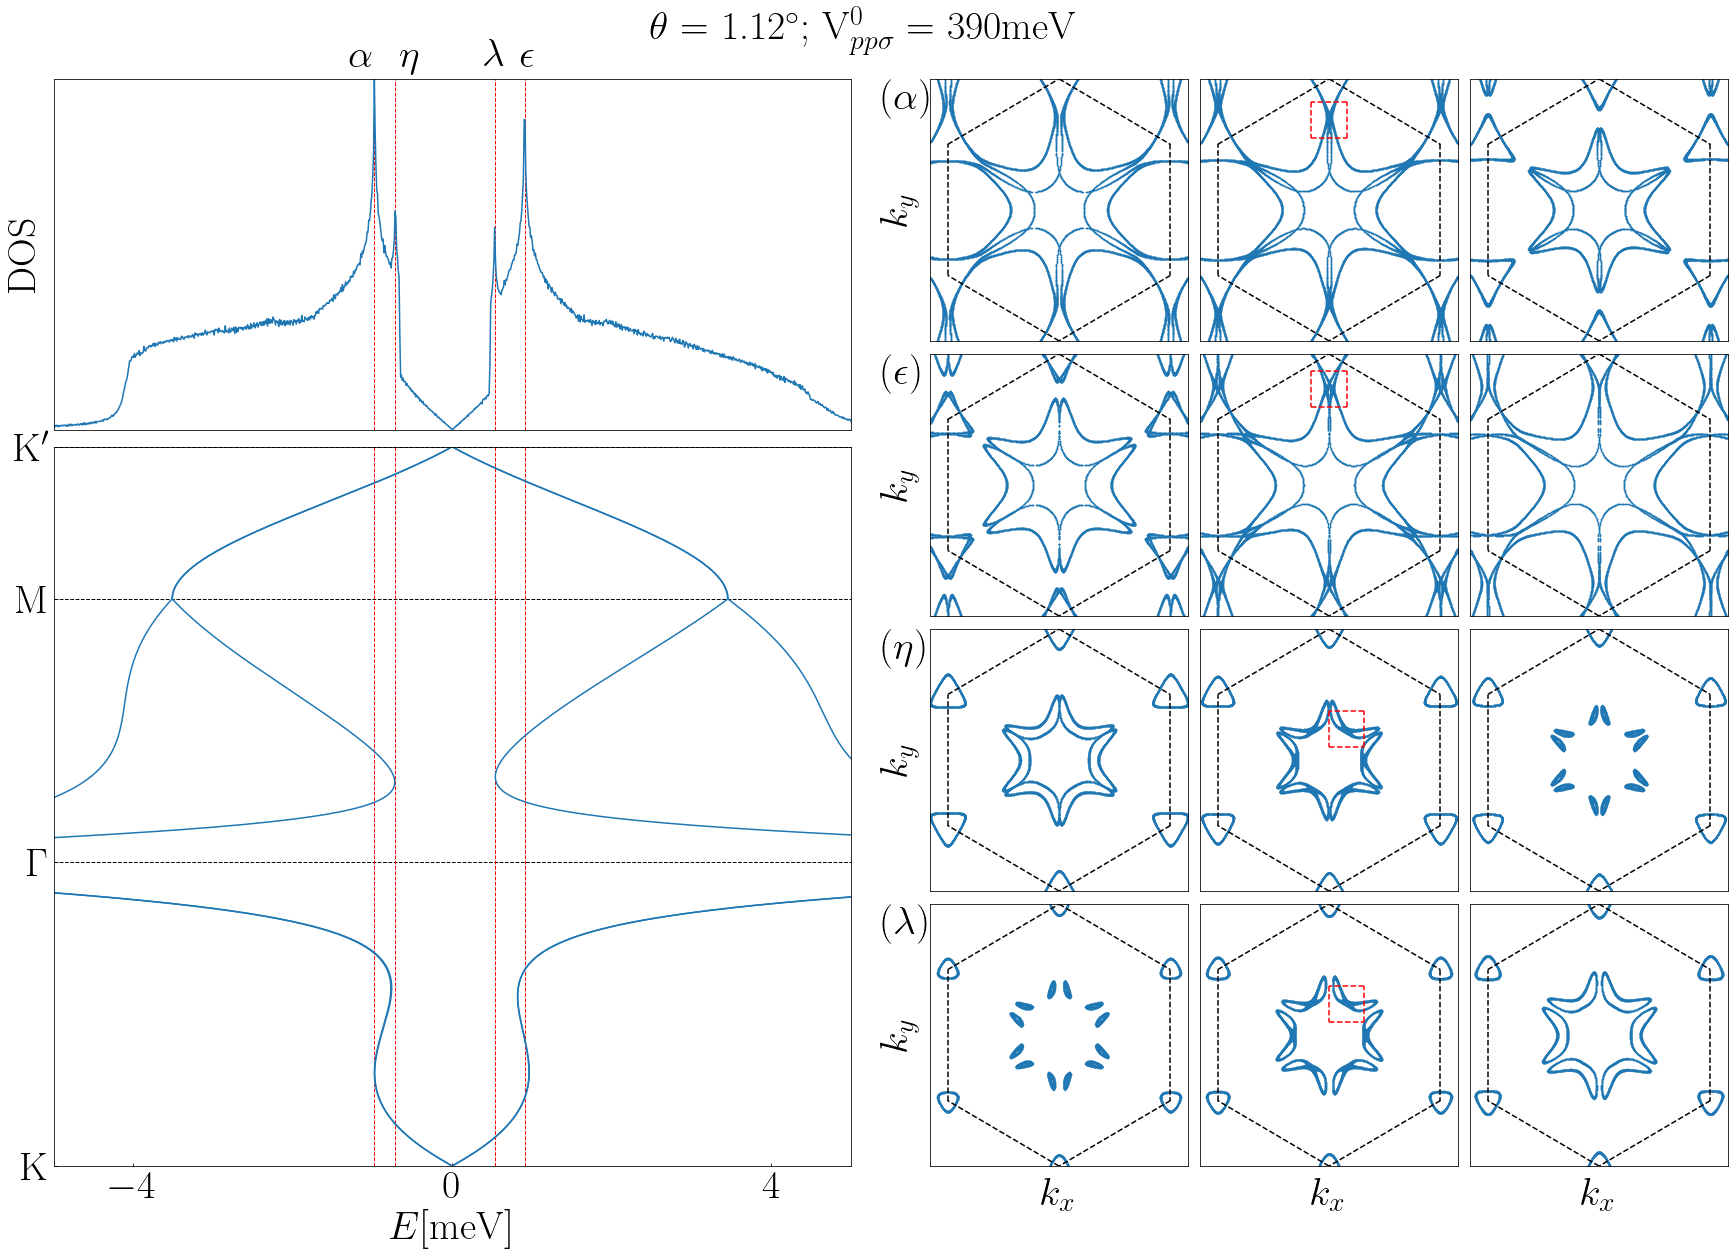

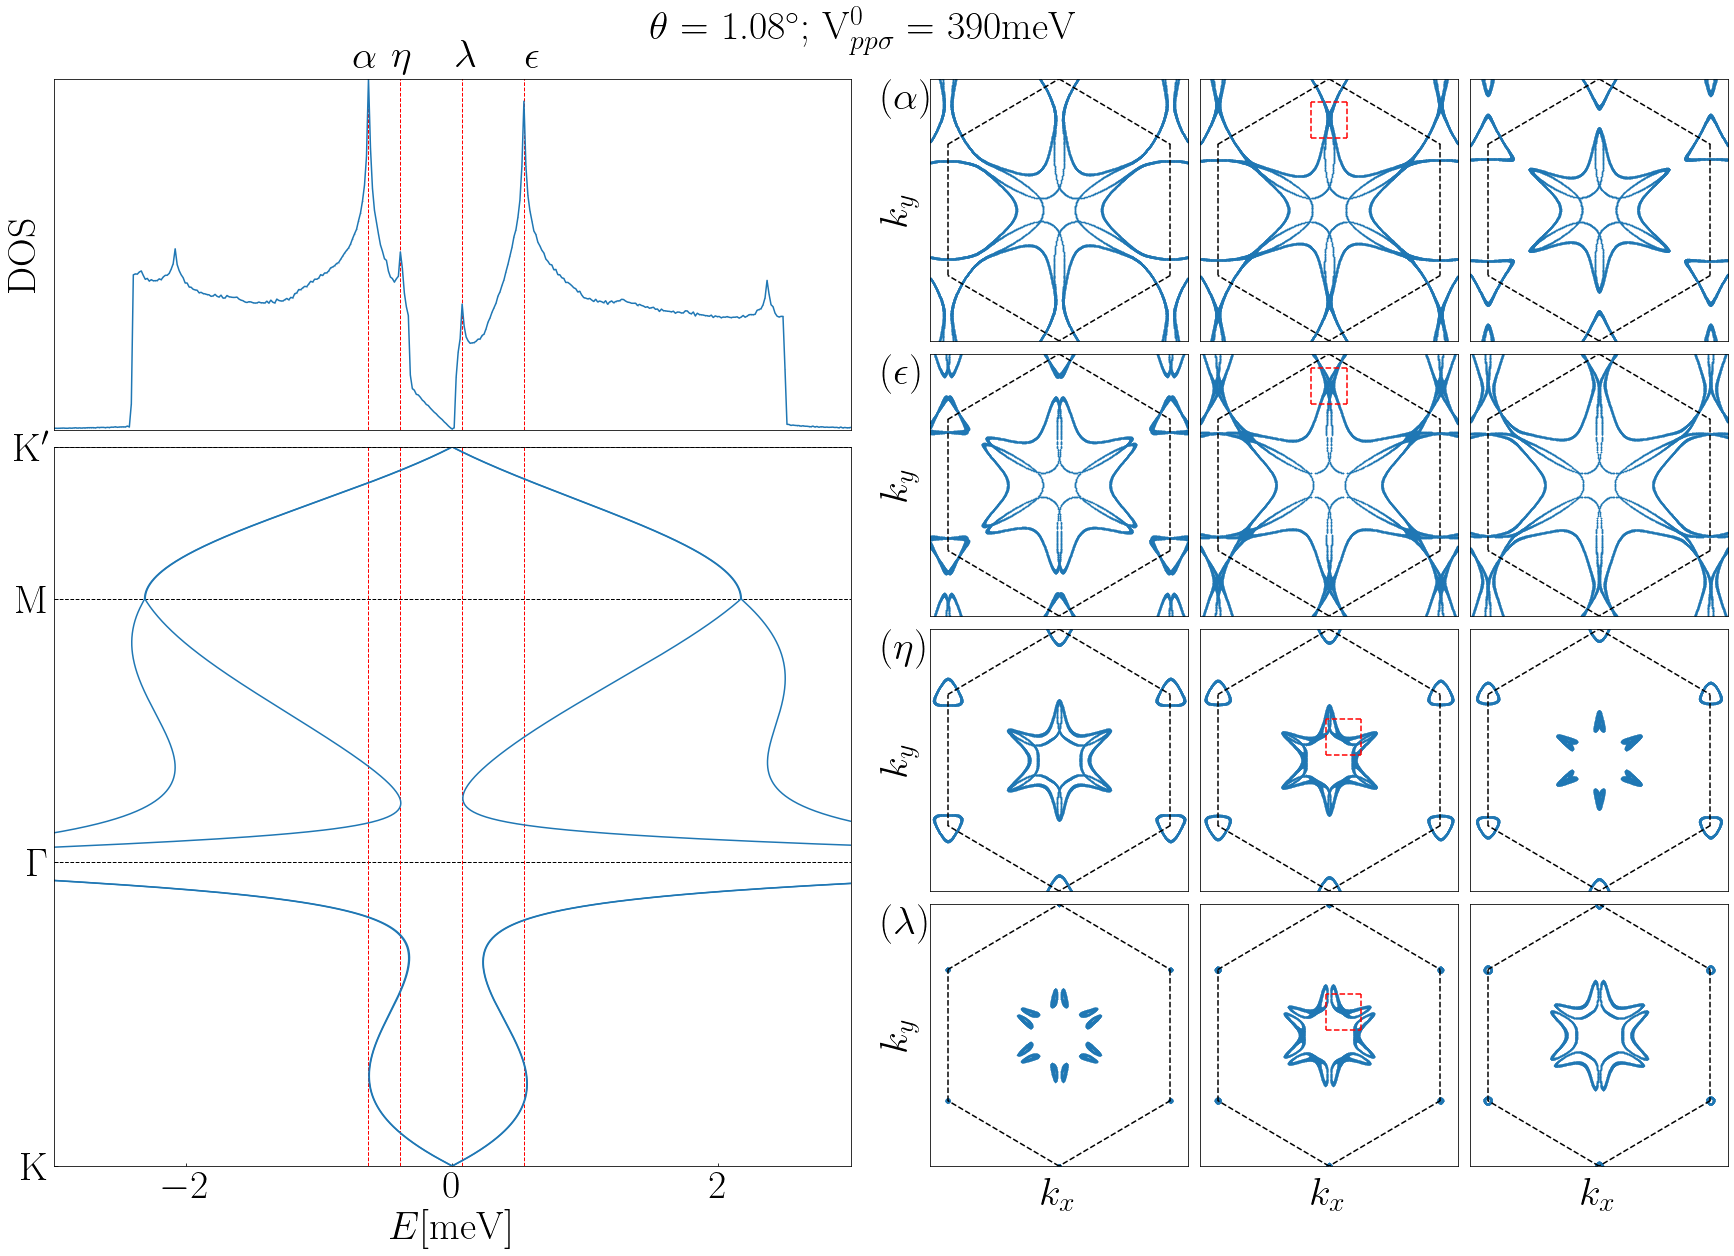

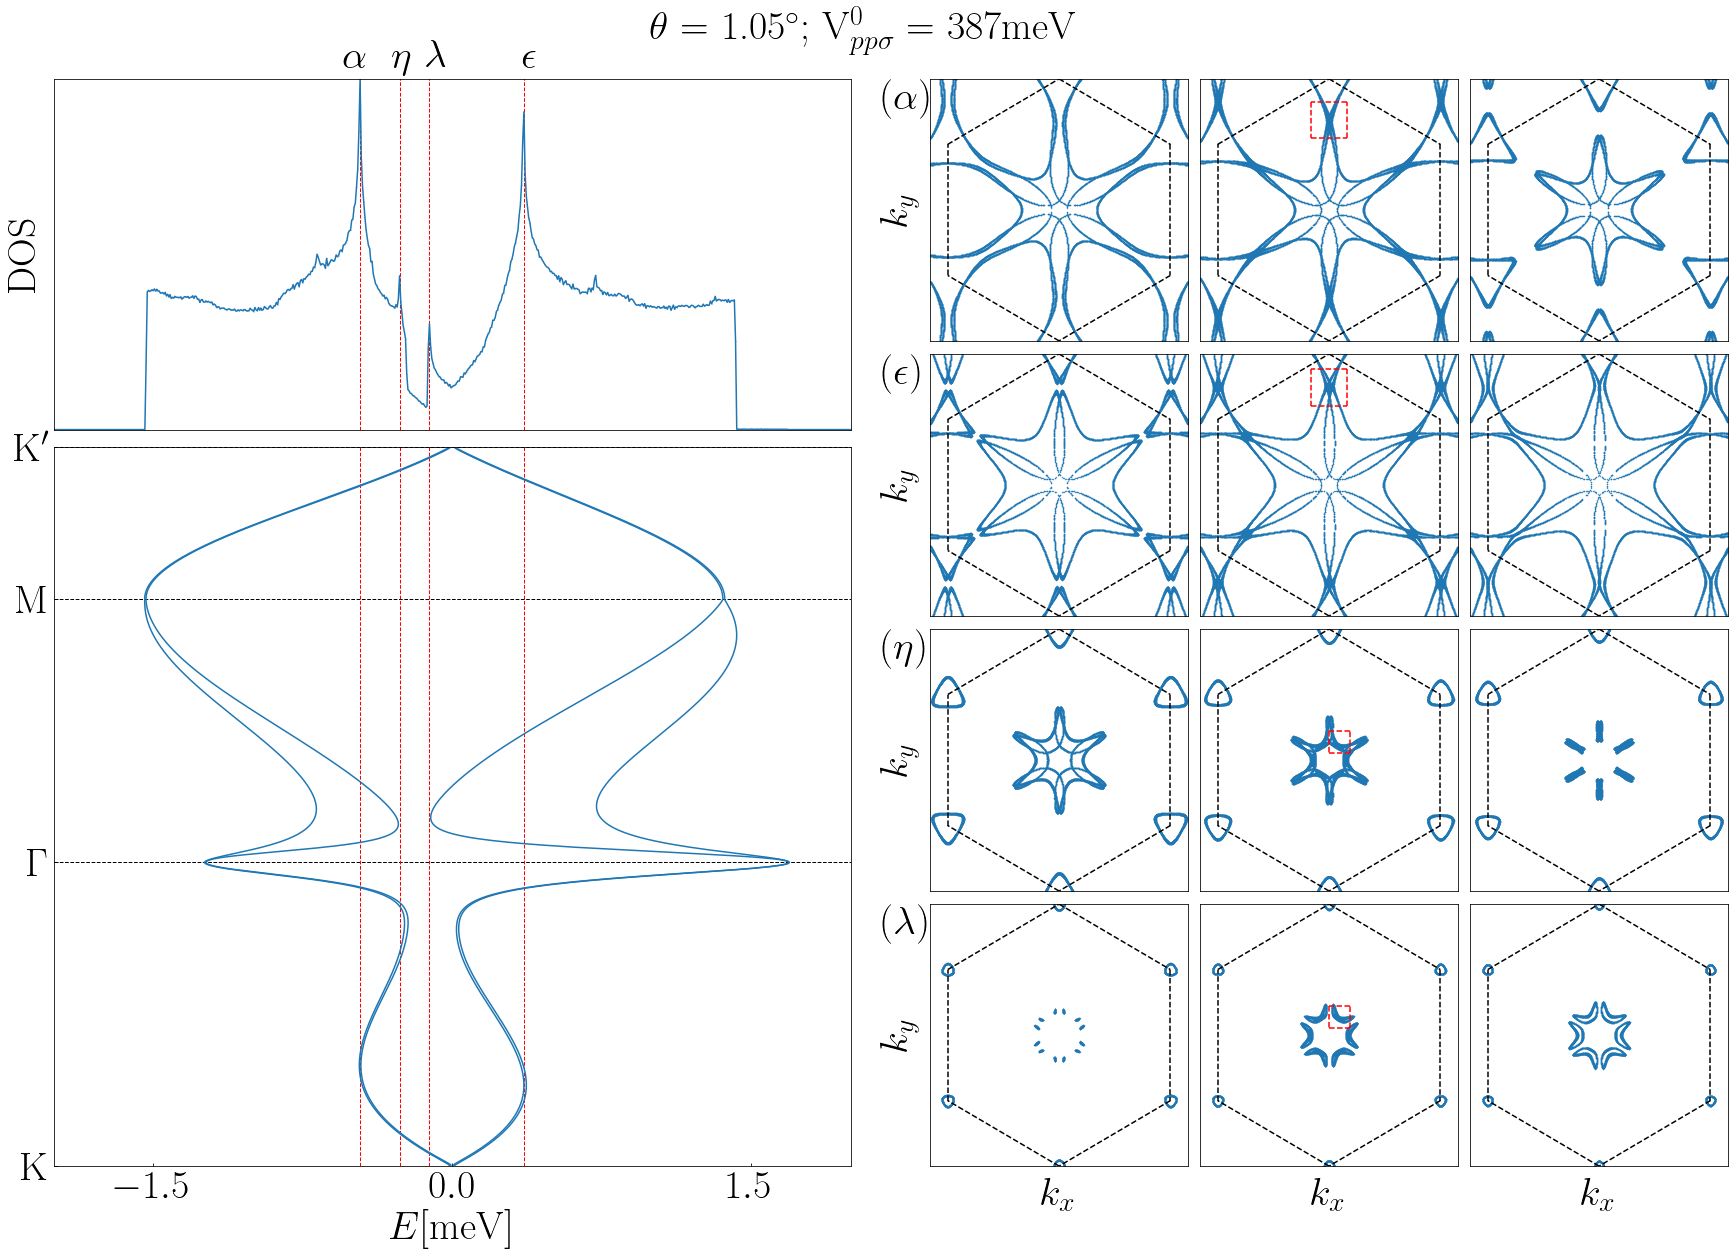

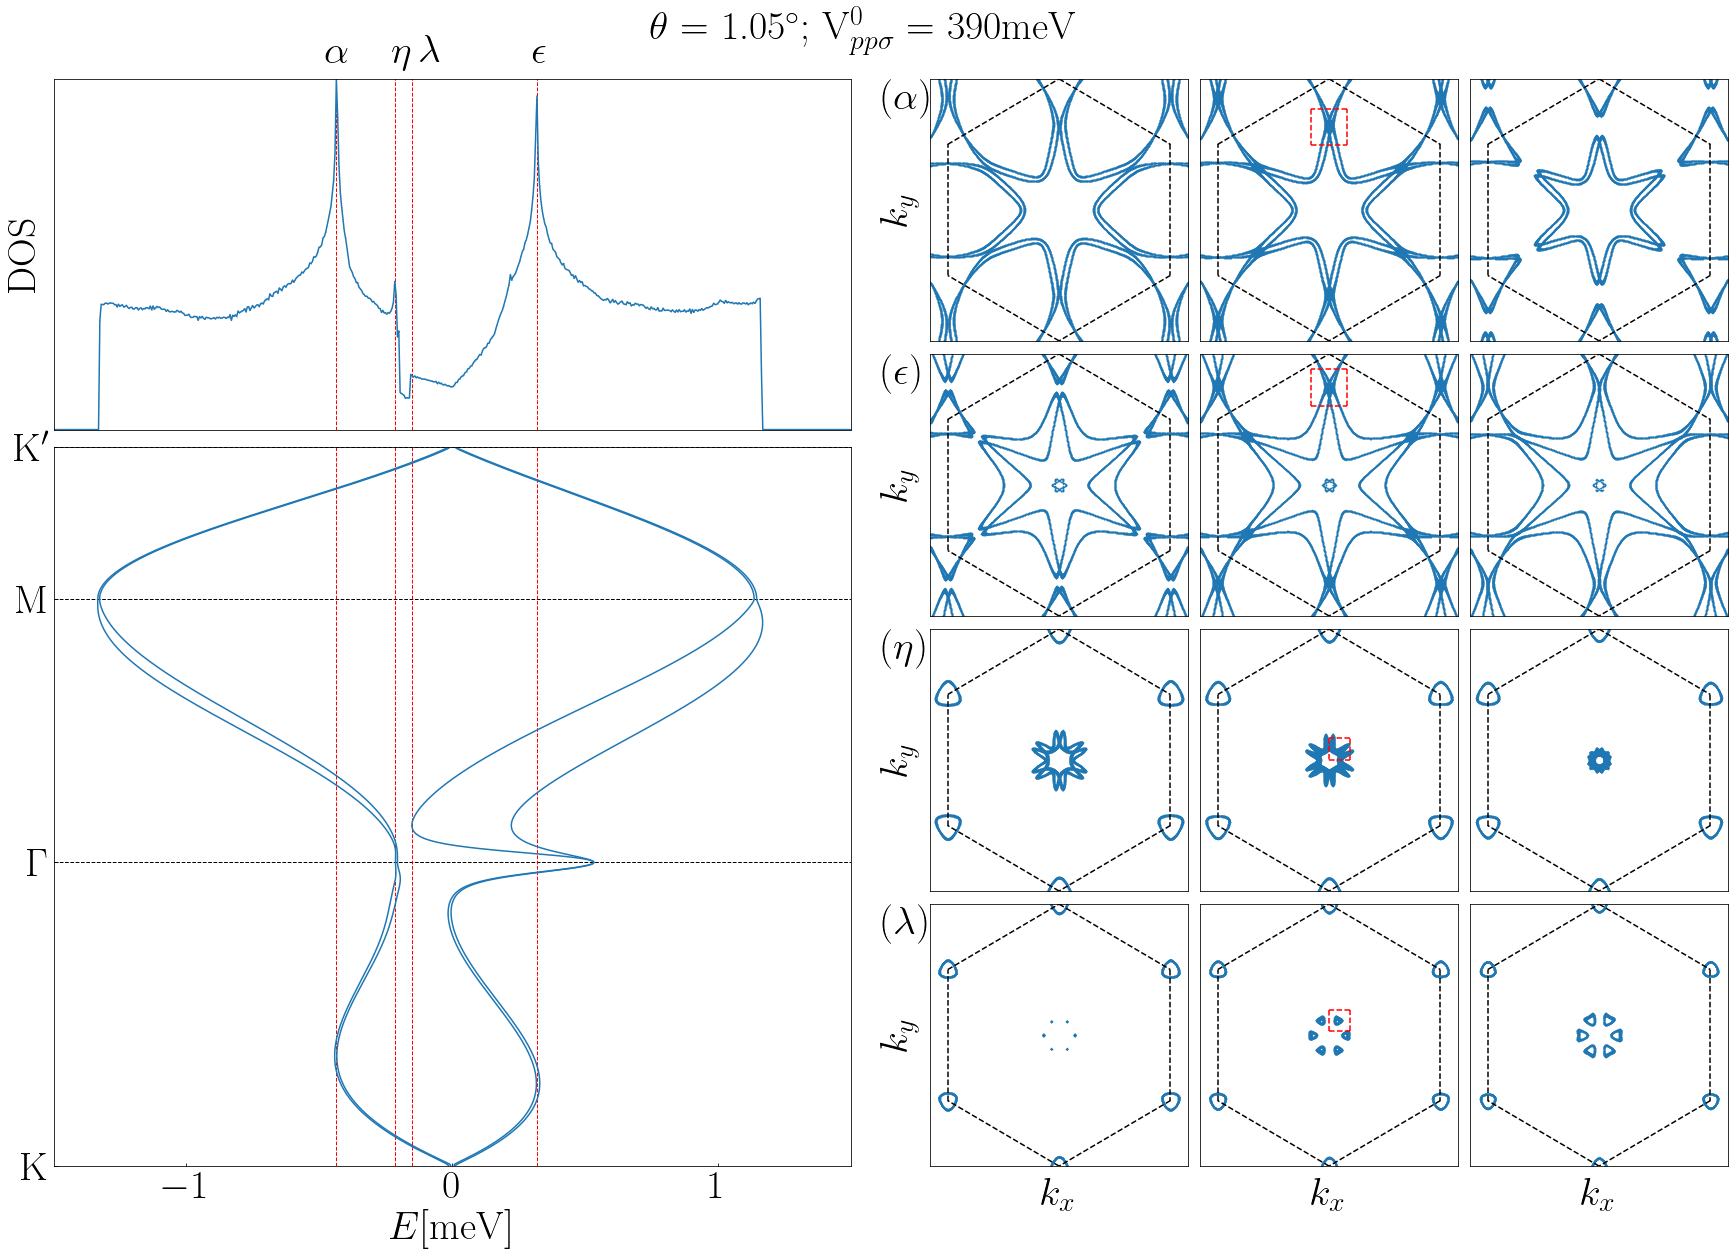

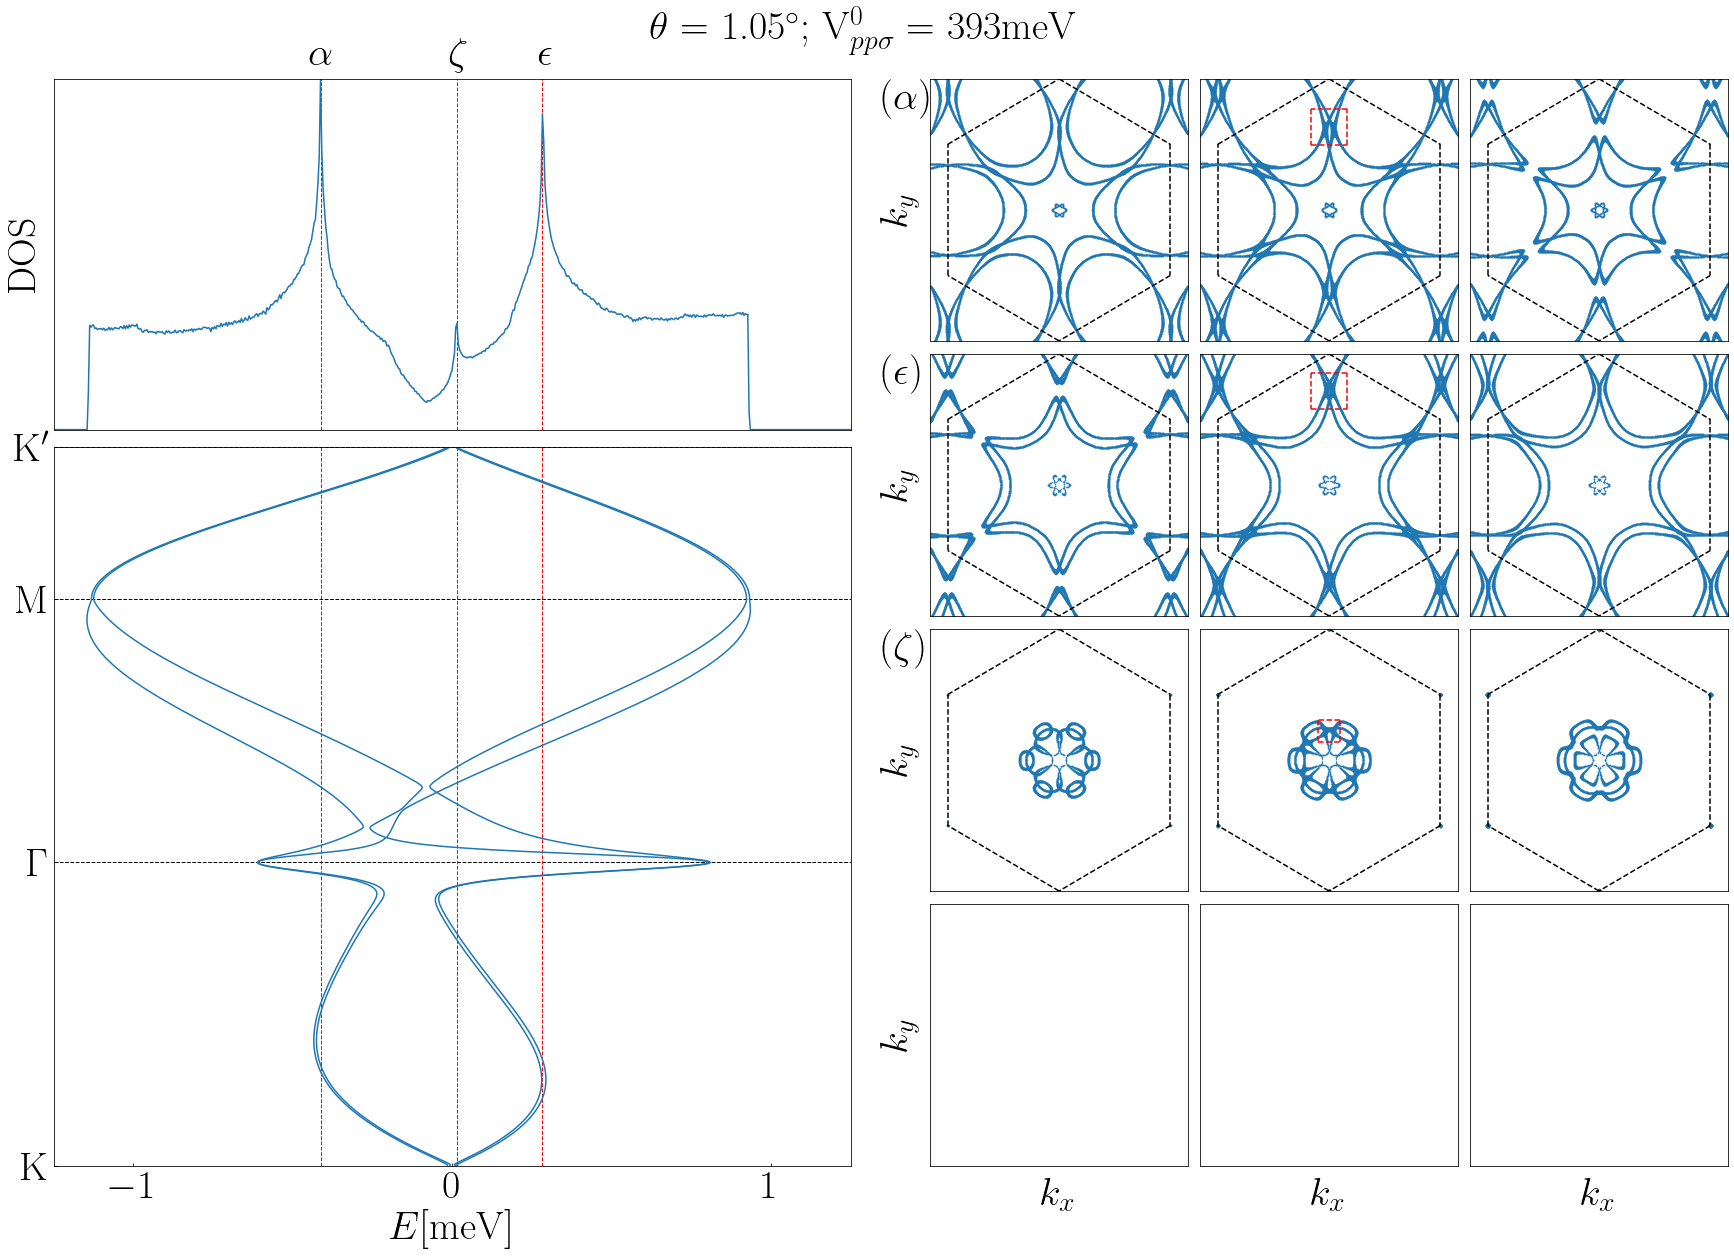

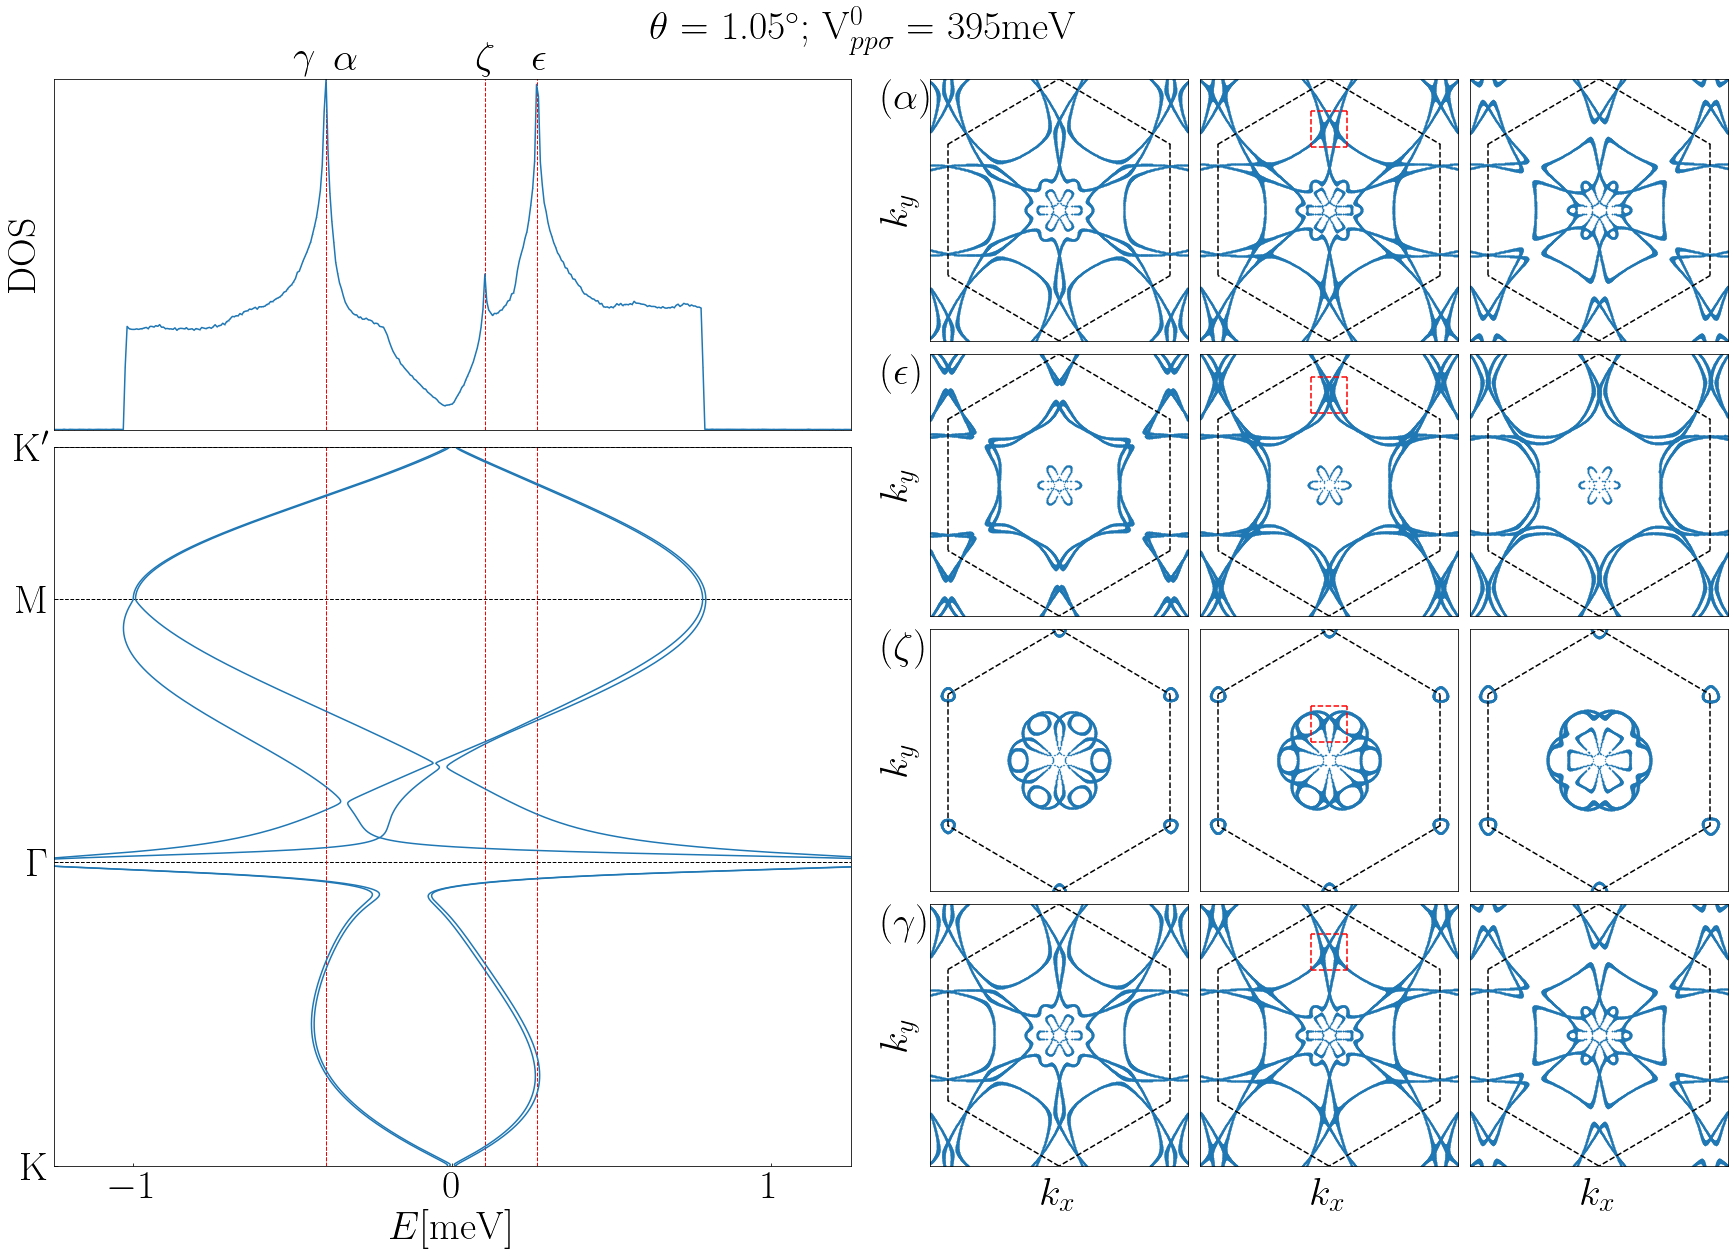

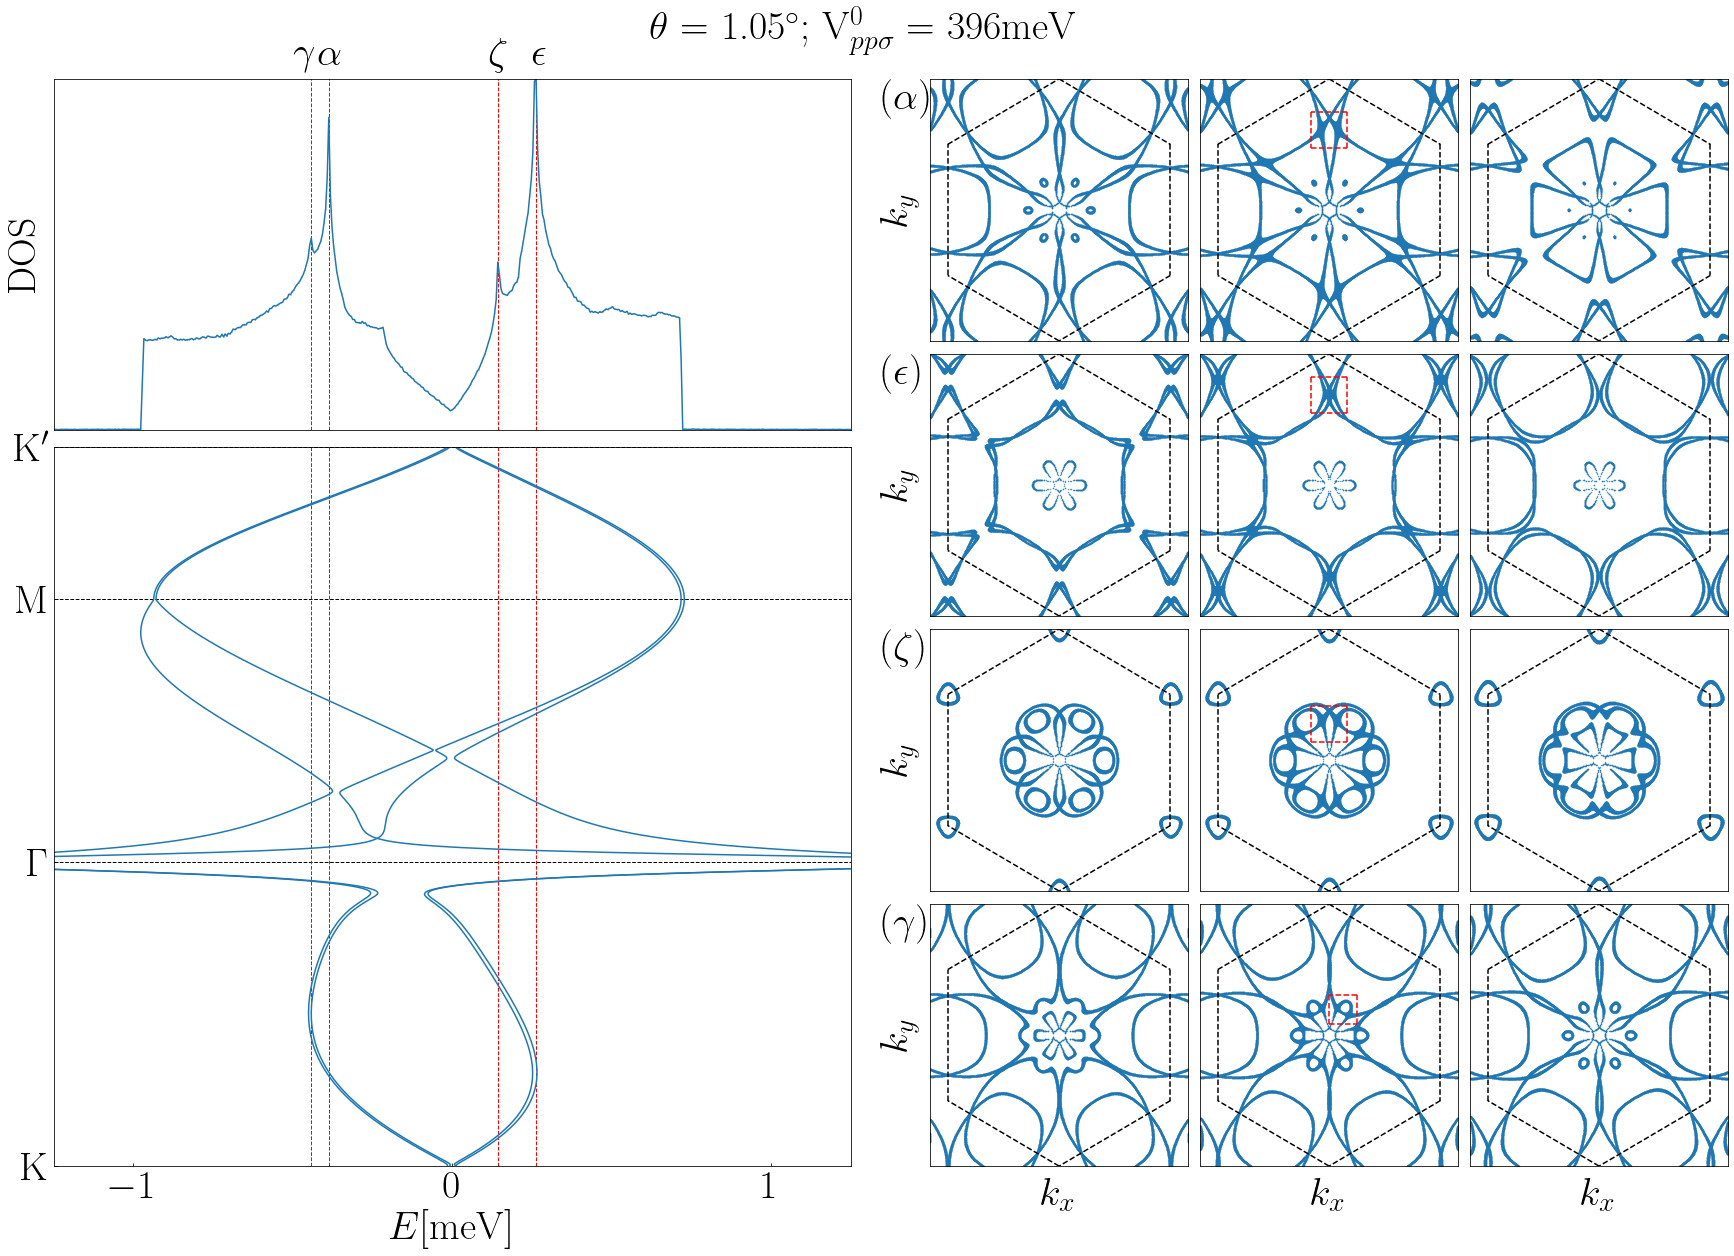

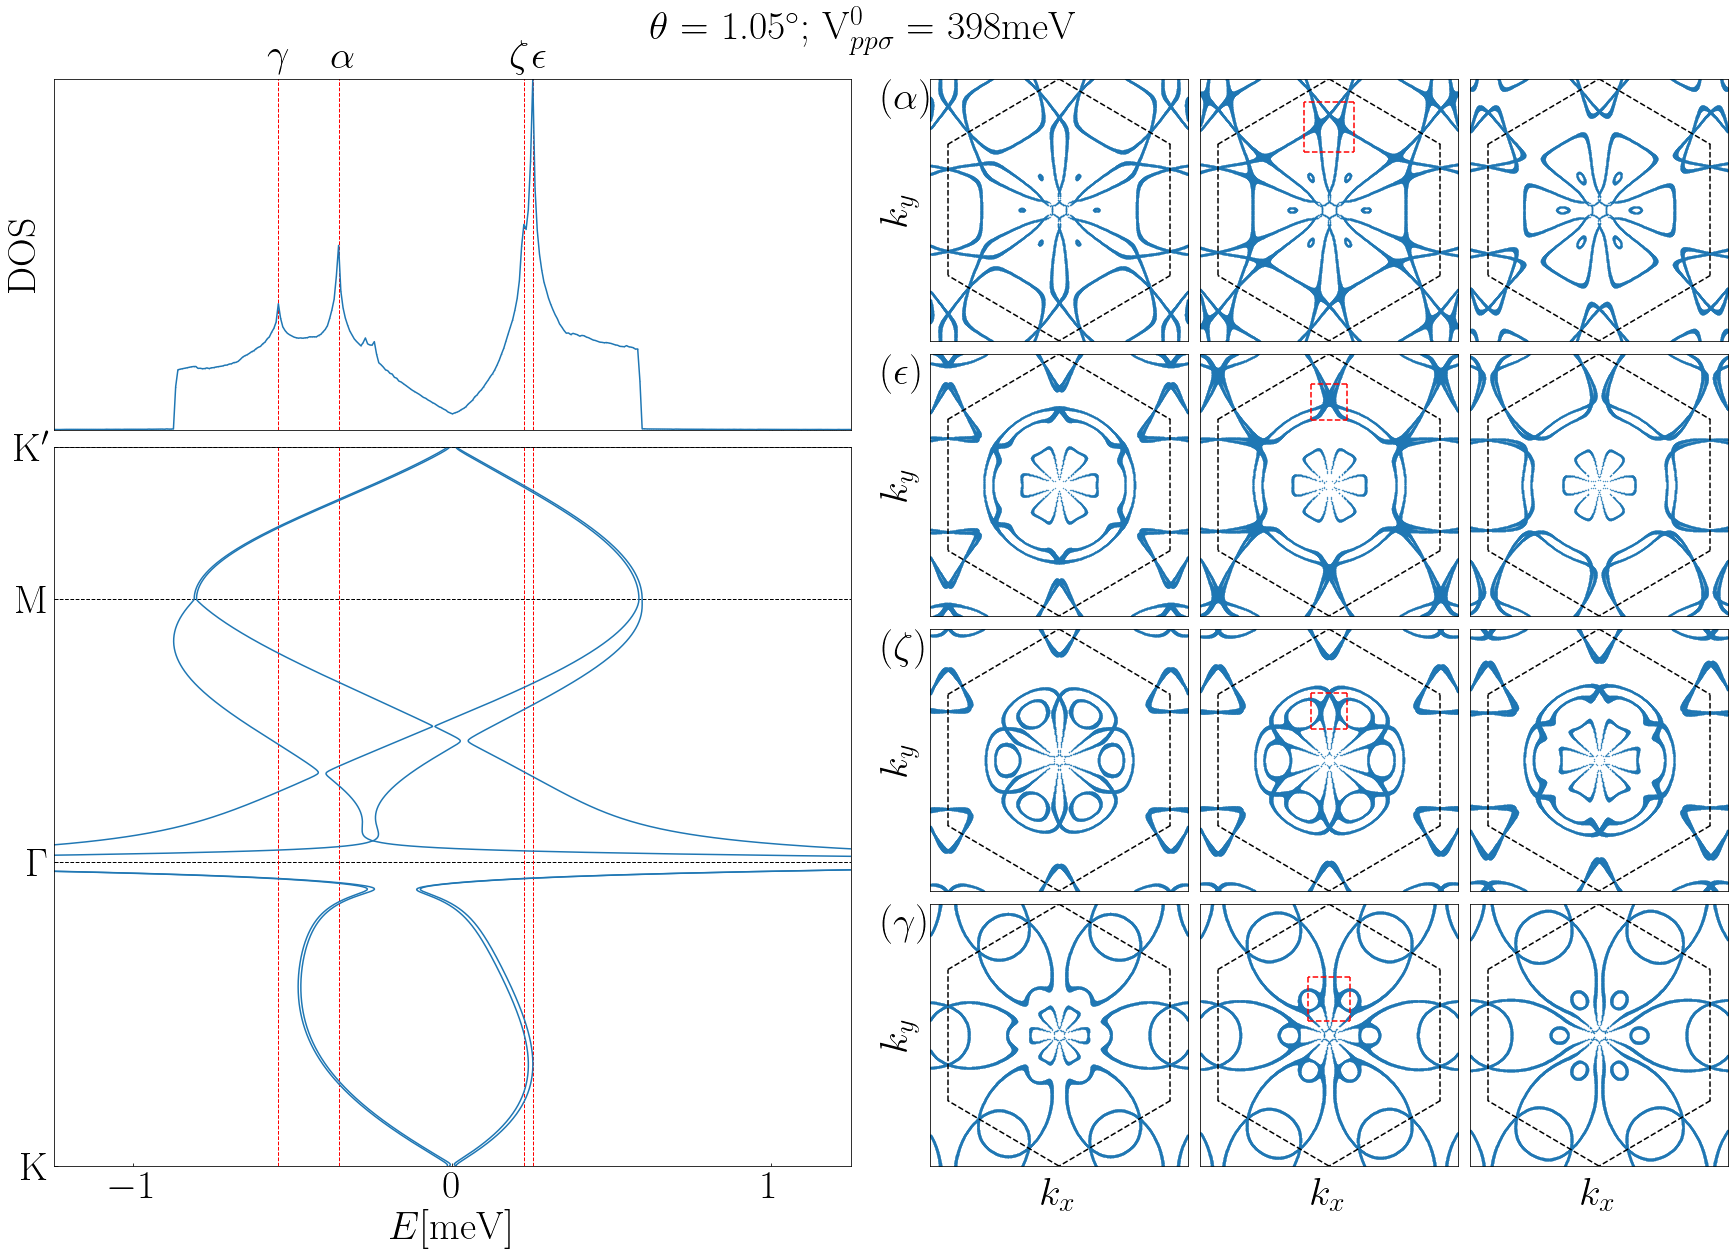

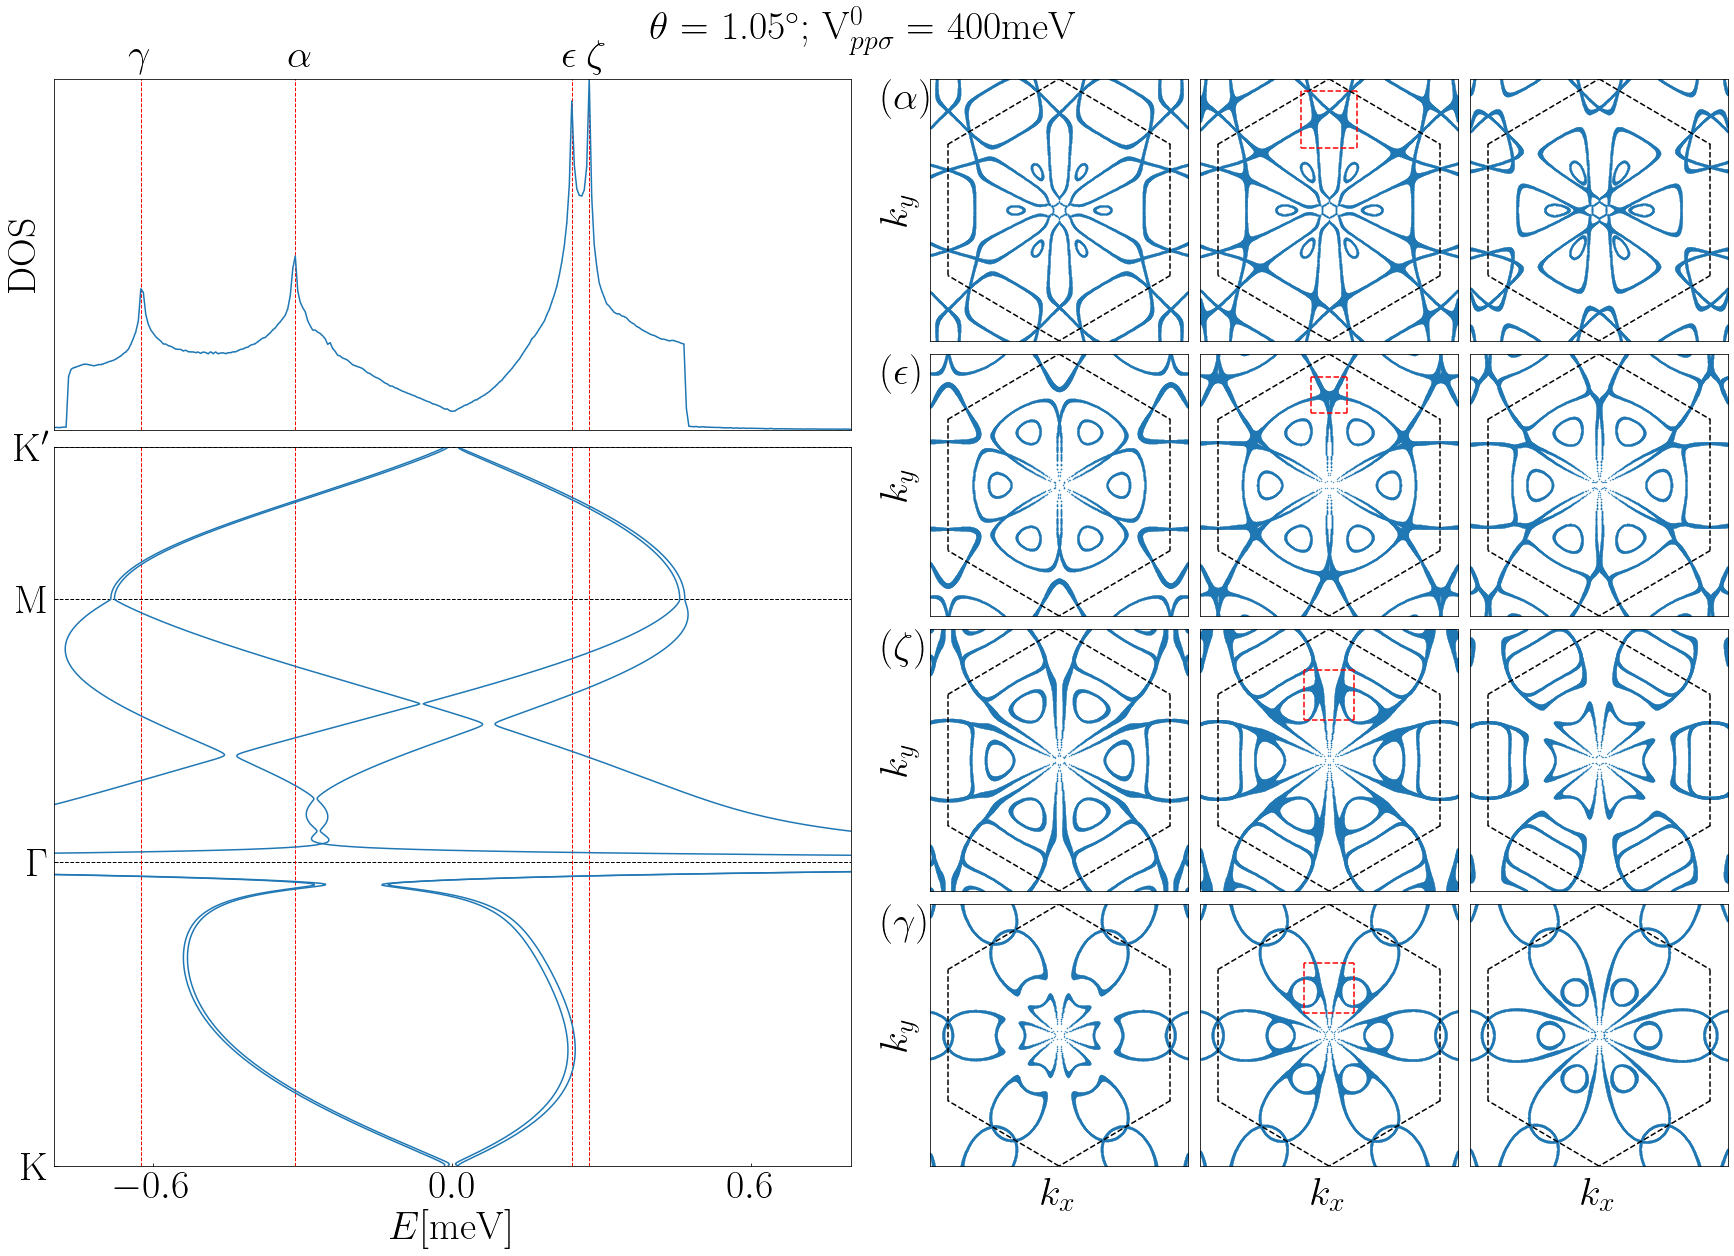

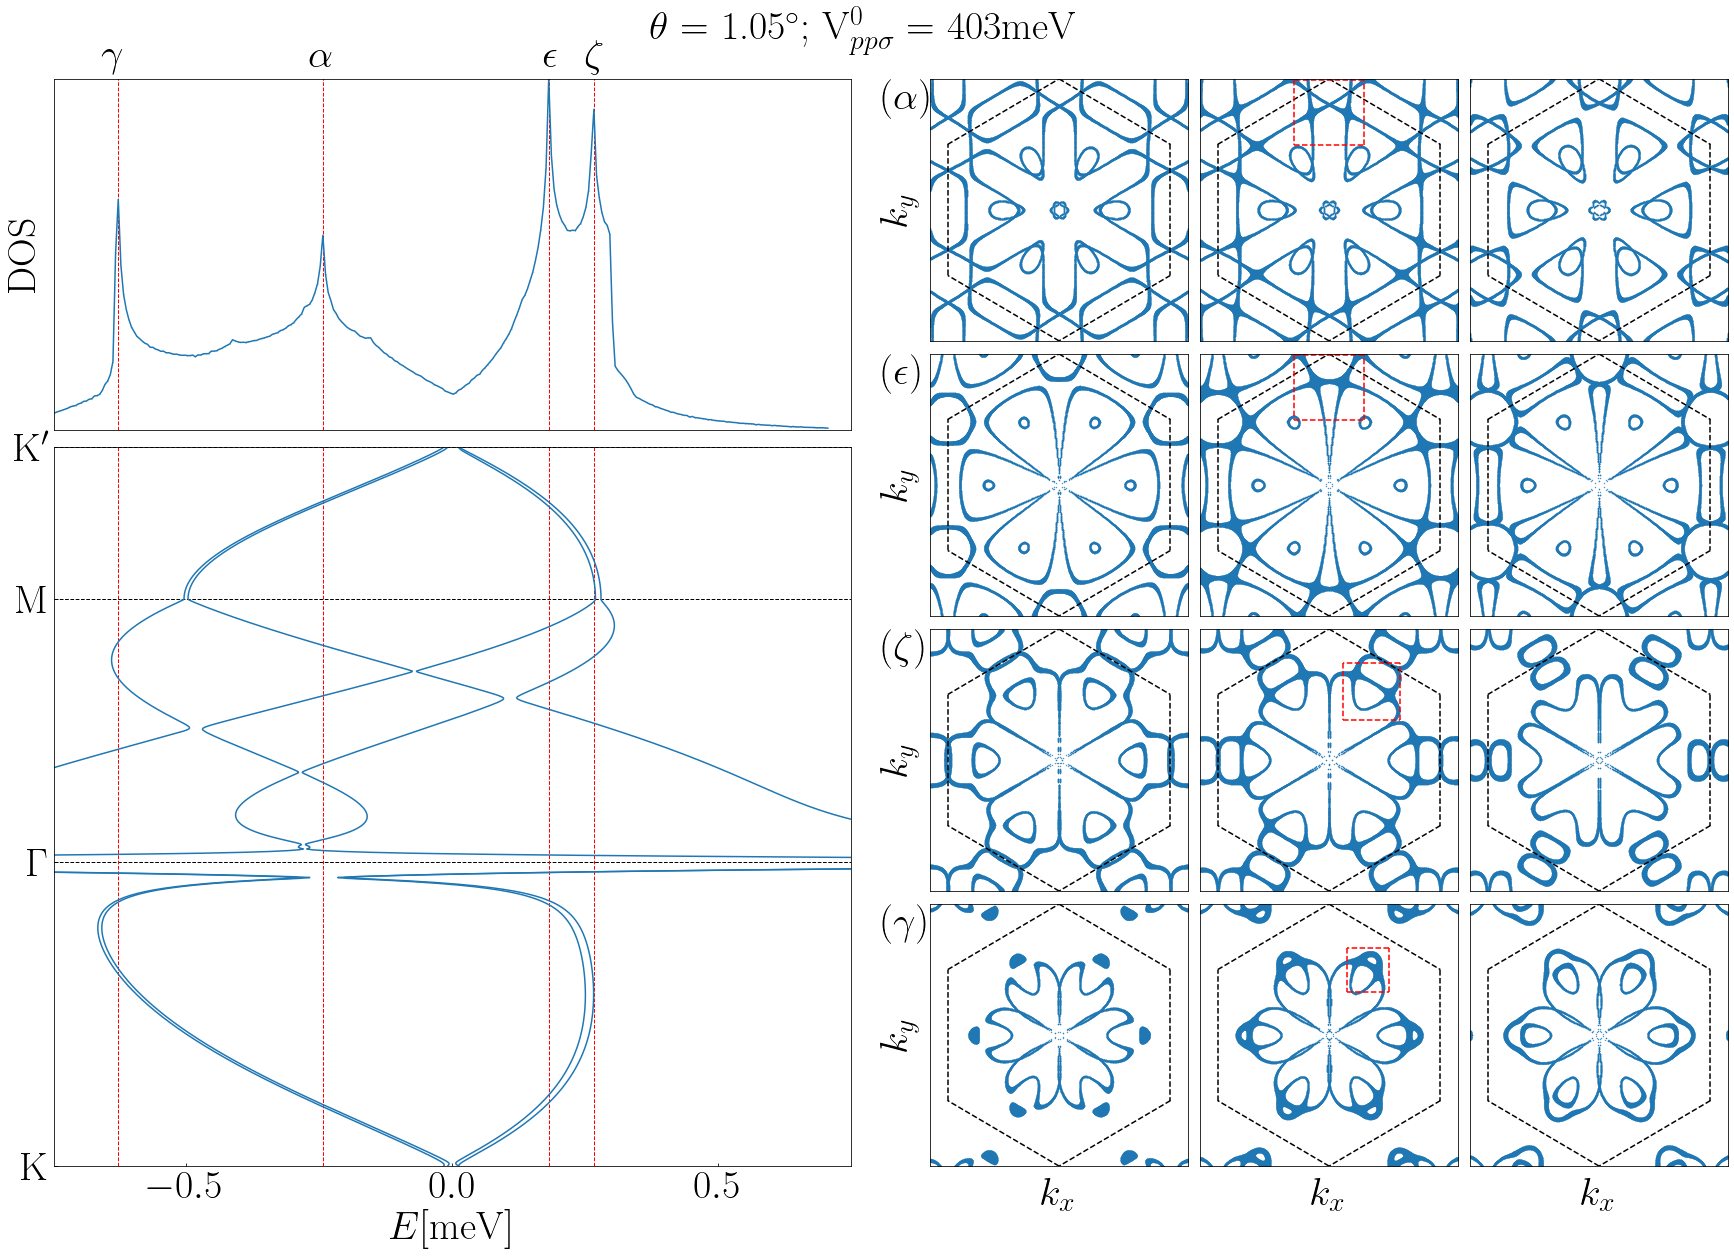

In [30]:
for i in range(11):
    plotter_gif(indeks = i, dE_array = dEs[i], delta_E_matrix = delta_Es[i], 
                VHS_labels= VHS_labels_matrix[i], label_positions=label_positions_matrix[i], 
                k_box_coords_array = k_box_coords_matrix[i],filename = "gif_{}.jpg".format(i))